# Imports and Load Data

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import seaborn as sns
import utils

In [323]:
splits_df = pd.read_csv('data/mj_splits_training_testing.csv')
labels    = np.repeat(np.array(splits_df['label']), 2)
training  = np.repeat(np.array(splits_df['training']), 2)
names     = np.repeat(np.array(splits_df['subject']), 2)
#indices = np.array([ 7,  8, 82, 42, 17, 51, 75, 20, 43, 15,  1, 52, 63, 59, 33, 50, 86, 31,  2, 45])


In [324]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [325]:
x_train, x_test = inputs[training == 1], inputs[training == 0]
y_train, y_test = labels[training == 1], labels[training == 0]

#x_train = np.stack([utils.symm_mat_to_ut_vec(utils.ut_vec_to_symm_mat(x_train[i])[indices, :][:, indices]) for i in range(x_train.shape[0])])
#x_test = np.stack([utils.symm_mat_to_ut_vec(utils.ut_vec_to_symm_mat(x_test[i])[indices, :][:, indices]) for i in range(x_test.shape[0])])

In [326]:
x_train.shape, x_test.shape

((516, 4005), (130, 4005))

# Unsupervised Learning Grid Search Best Num Classes

In [15]:
import utils as uu
import importlib
importlib.reload(uu)

import sklearn.neighbors
import sklearn.linear_model

In [16]:
def get_clusters(model, x, n):
    clustered_ins = model.predict(x)
    dense_clust_in = np.zeros((clustered_ins.shape[0], n))
    dense_clust_in[np.arange(clustered_ins.shape[0]), clustered_ins] = 1
    
    return dense_clust_in

100%|███████████████████████████████████████████| 18/18 [00:29<00:00,  1.66s/it]


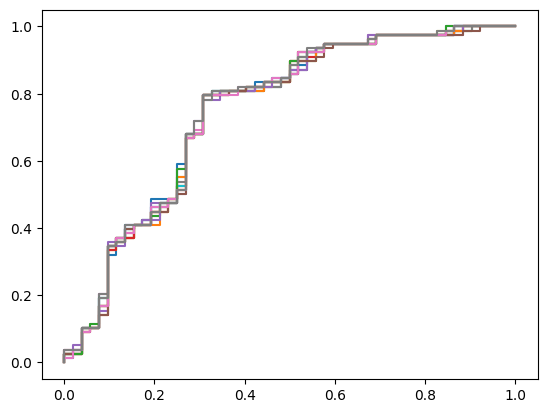

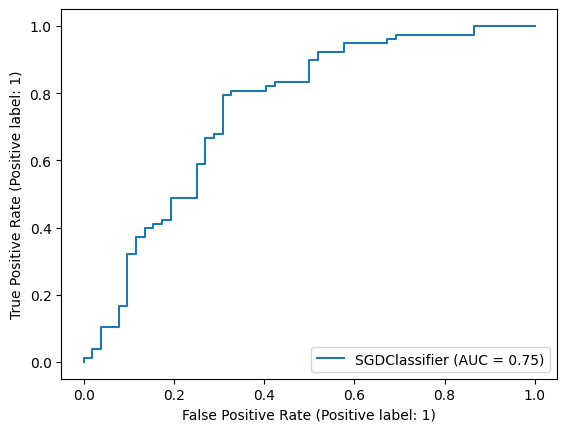

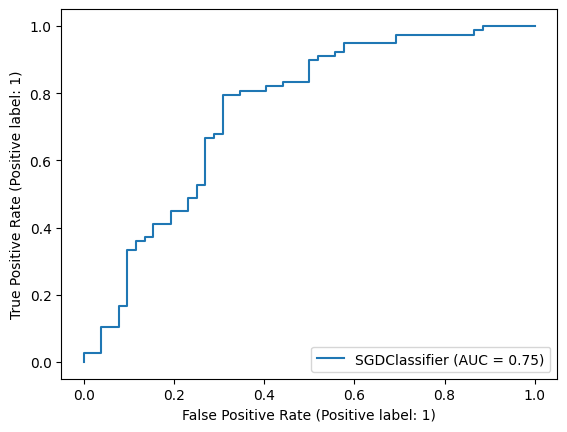

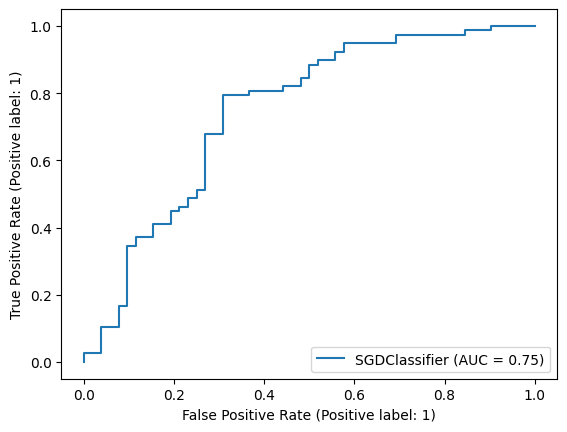

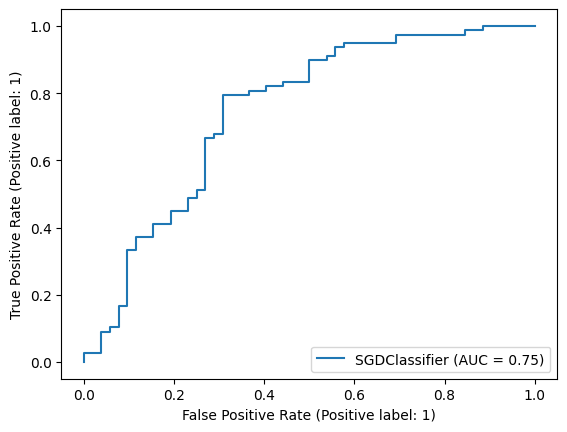

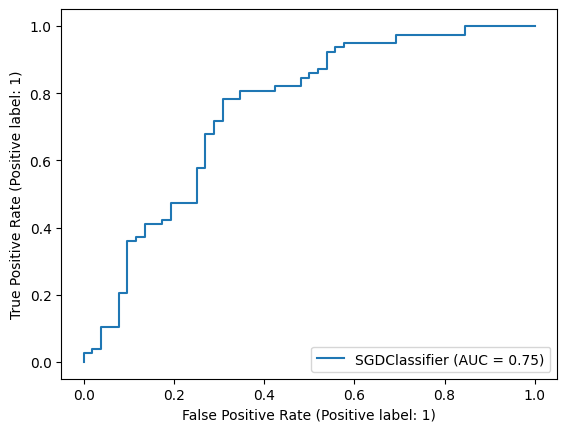

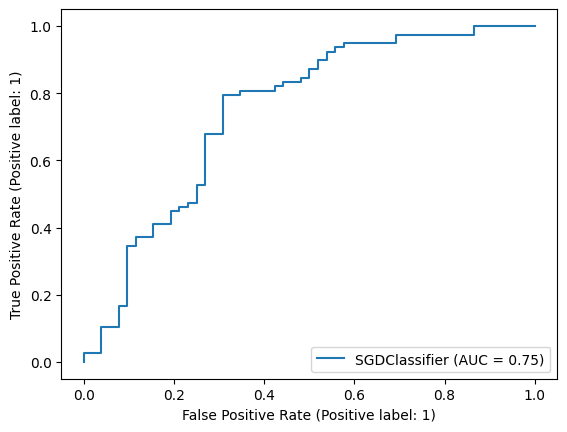

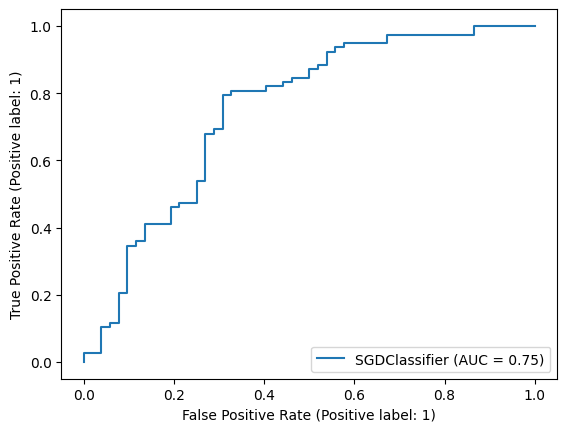

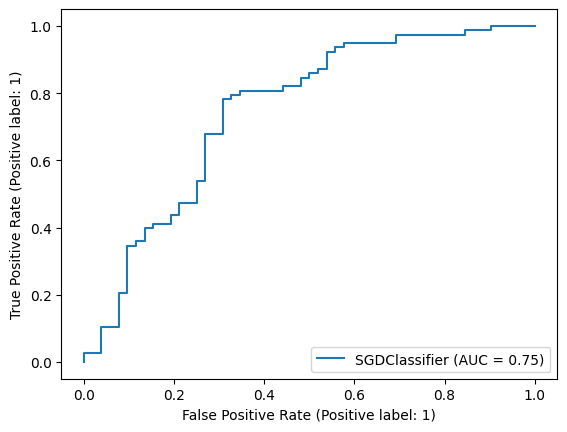

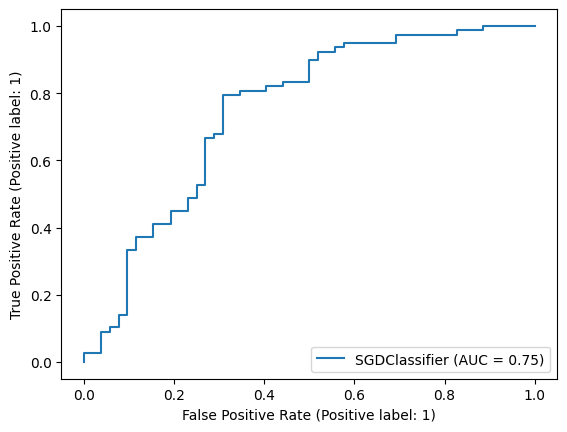

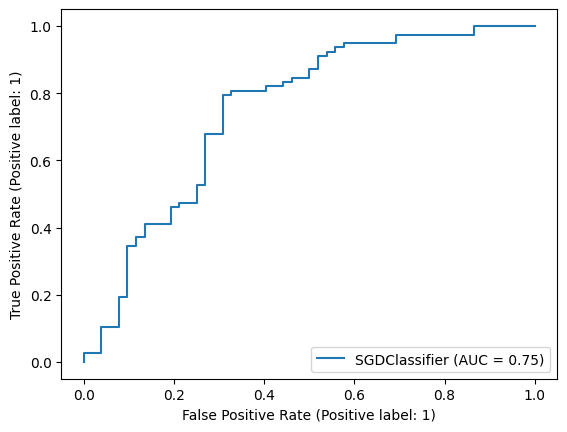

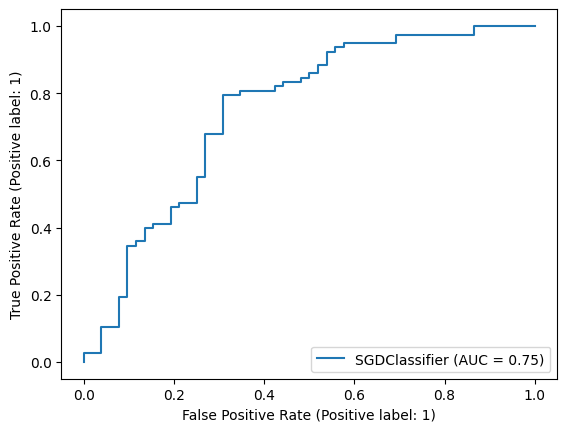

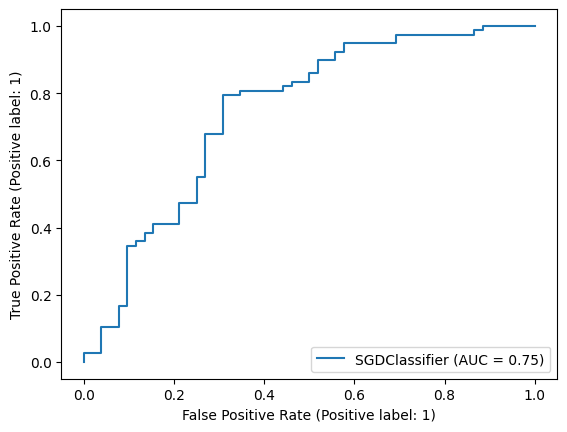

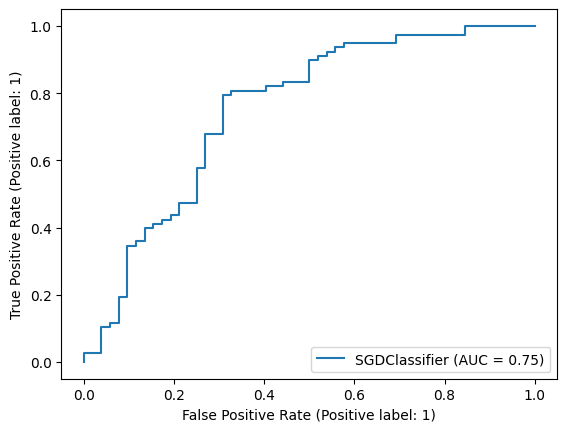

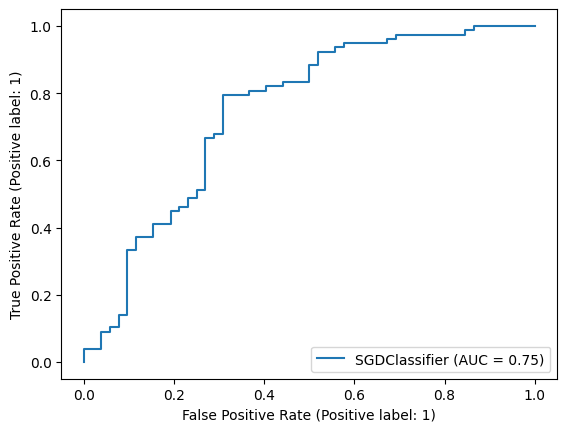

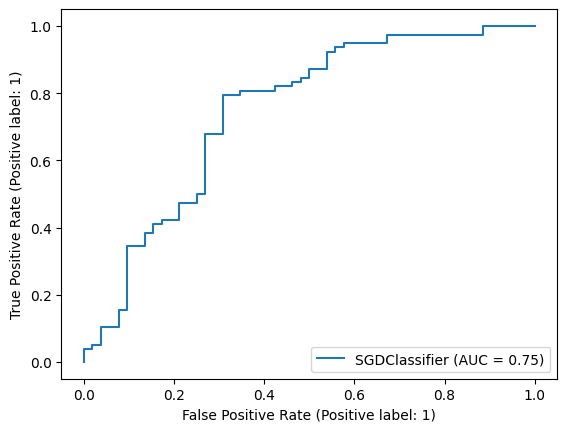

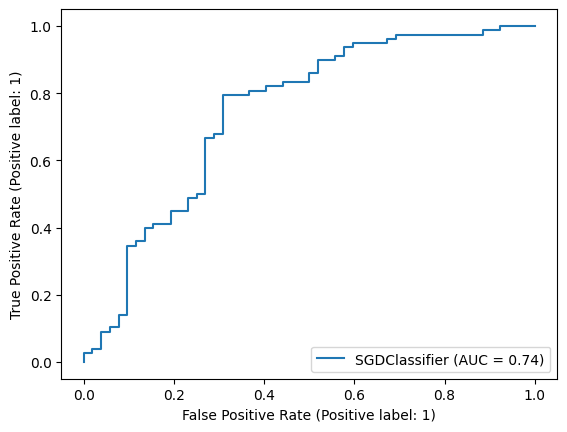

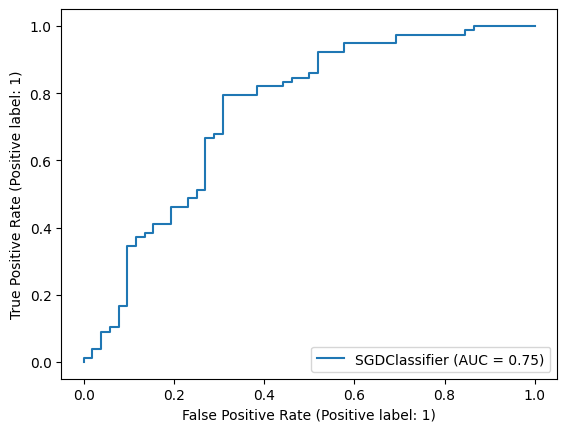

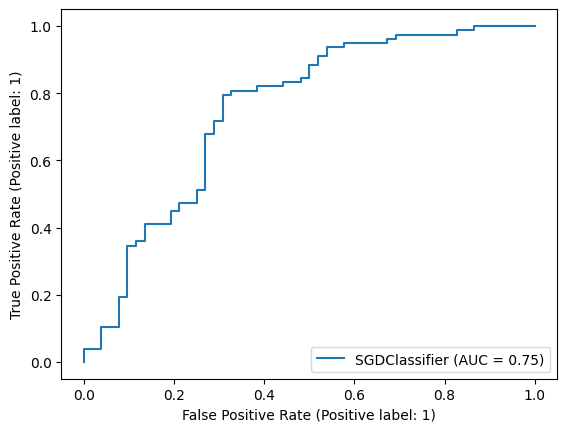

In [48]:
import tqdm

cluster_nums = list(range(2, 20))
cluster_metrics = {}

fig, ax = plt.subplots()

for n in tqdm.tqdm(cluster_nums):
    cluster_metrics[n] = {}
    
    unsup_model = sklearn.cluster.KMeans(n, n_init=10, random_state=1)
    unsup_model.fit(x_train)
    
    class_model = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, random_state=42)
    
    #class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
    x_trans = unsup_model.transform(x_train)
    x_trans /= np.sum(x_trans, axis=1)[:, np.newaxis]
    class_model.fit(x_trans, y_train)

    #auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model, 
                                                              #get_clusters(unsup_model, x_test, n), y_test, ax=None)
    test_x_trans = unsup_model.transform(x_test)
    test_x_trans /= np.sum(test_x_trans, axis=1)[:, np.newaxis]
    auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model, 
                                                              test_x_trans, y_test, ax=None)
    tpr, fpr = auc_data.tpr, auc_data.fpr
    
    ax.plot(fpr, tpr, label=f"{n} clusters: AUC {np.round(auc_data.roc_auc, 4)}")
    
    cluster_metrics[n]['auc'] = auc_data.roc_auc



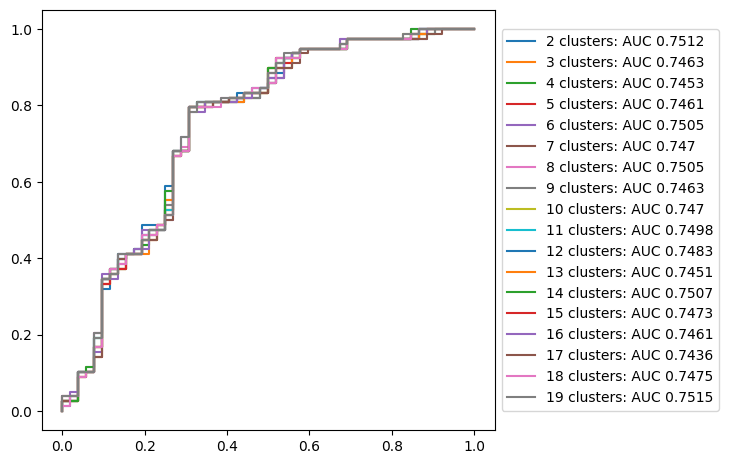

In [49]:
handles, fig_labels = ax.get_legend_handles_labels()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(handles, fig_labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig

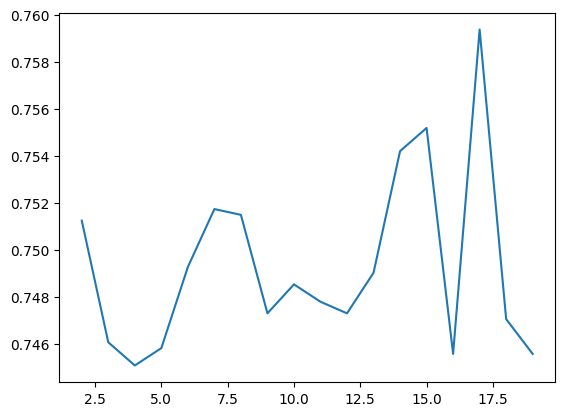

In [767]:
plt.plot(list(cluster_metrics.keys()), [v["auc"] for _, v in cluster_metrics.items()])

# Experiments with N Clusters

In [17]:
import seaborn as sns
import heavytools as hv
import sklearn.cluster

In [18]:
def transform(model, x):
    trans = model.transform(x)
    trans /= np.sum(trans, axis=1)[:, np.newaxis]
    
    return trans

(0.6282051282051282, 0.5923076923076923)

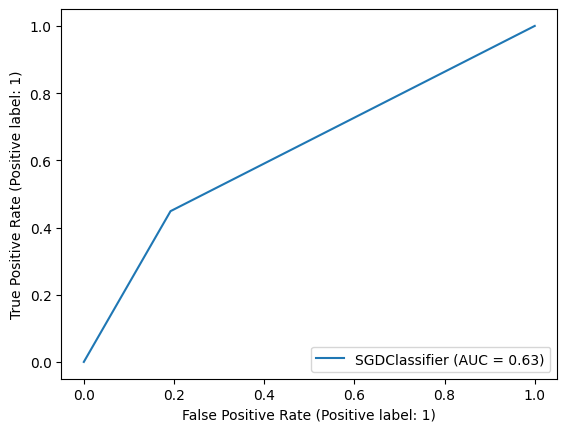

In [72]:
n = 2

unsup_model = sklearn.cluster.KMeans(n, n_init=10, random_state=1)
unsup_model.fit(x_train)

class_model = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.001, random_state=42)

class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
#class_model.fit(transform(unsup_model, x_train), y_train)


auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model, get_clusters(unsup_model, x_test, n), y_test, ax=None)

auc_data.roc_auc, class_model.score(get_clusters(unsup_model, x_test, n), y_test)

(0.751232741617357, 0.6307692307692307)

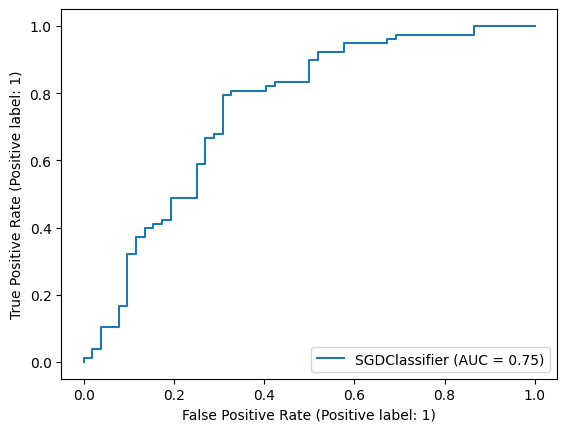

In [73]:
n = 2

unsup_model = sklearn.cluster.KMeans(n, n_init=10, random_state=1)
unsup_model.fit(x_train)

class_model = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.001, random_state=42)

#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
class_model.fit(transform(unsup_model, x_train), y_train)


auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model, 
                                                              transform(unsup_model, x_test), y_test, ax=None)

auc_data.roc_auc, class_model.score(transform(unsup_model, x_test), y_test)

In [74]:
np.mean(unsup_model.predict(x_train) == y_train), np.mean(y_train)

(0.5872093023255814, 0.6046511627906976)

In [75]:
clustered = unsup_model.predict(inputs)

in_clusters = {}
for i in range(n):
    in_clusters[i] = inputs[clustered == i]


<Axes: >

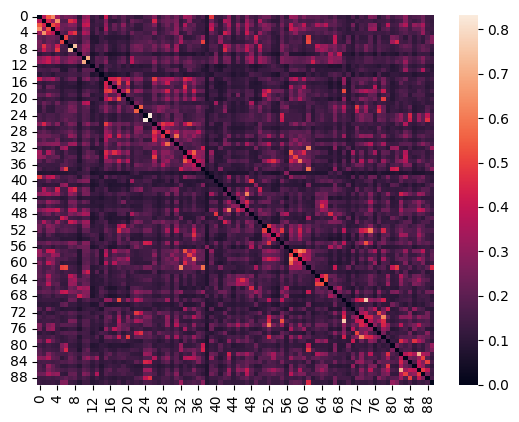

In [76]:
sns.heatmap(hv.convert_triangle_to_mat(np.mean(np.abs(inputs), axis=0)))

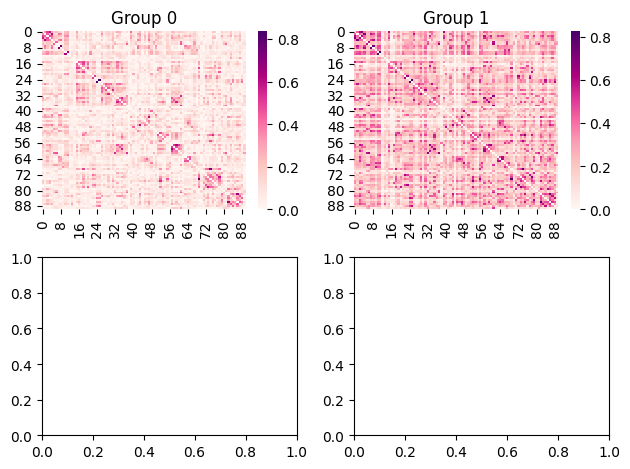

In [77]:
dp = int(np.ceil(np.sqrt(n)))


fig, ax = plt.subplots(dp, dp)

for i in range(n):
    sns.heatmap(hv.convert_triangle_to_mat(np.abs(unsup_model.cluster_centers_[i])), 
                ax=ax[i//dp, i%dp], cmap="RdPu")
    ax[i//dp, i%dp].set(title=f"Group {i}")

fig.tight_layout()

In [78]:
unsup_model.cluster_centers_[0].shape

(4005,)

In [79]:
for c in unsup_model.cluster_centers_:
    print(c.shape)

(4005,)
(4005,)


In [80]:
np.array([x_train * c for c in unsup_model.cluster_centers_]).shape

(2, 516, 4005)

In [81]:
np.mean([x_train * c for c in unsup_model.cluster_centers_], axis=0).shape

(516, 4005)

0.8357988165680473

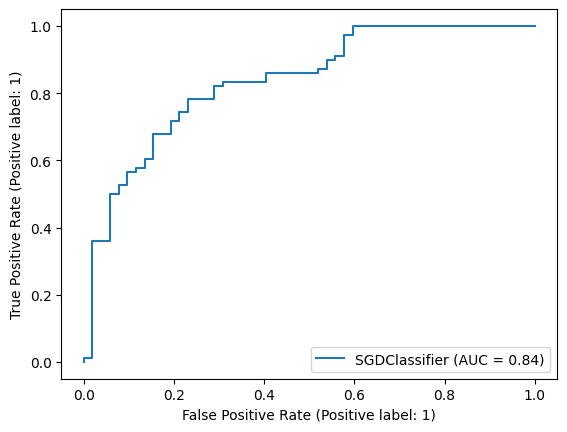

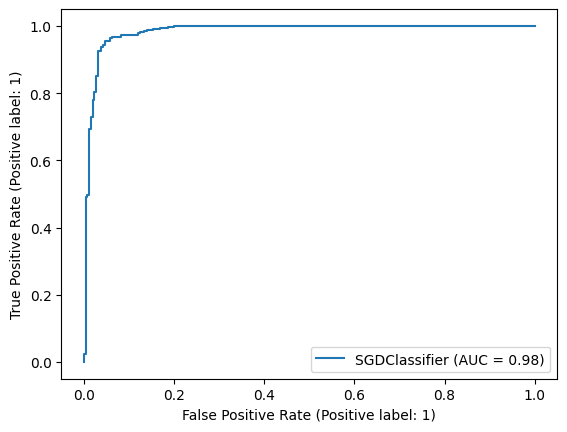

In [82]:
class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.001, random_state=1)

rand_clusters = np.random.random((n, 4005))

#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
x_train2 = np.concatenate([x_train * c for c in rand_clusters], axis=1)
x_test2 = np.concatenate([x_test * c for c in rand_clusters], axis=1)
inputs2 = np.concatenate([inputs * c for c in rand_clusters], axis=1)

class_model2.fit(x_train2, y_train)

auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, y_test, ax=None)
tot_auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              inputs2, labels, ax=None)

auc_data.roc_auc

0.8436883629191322

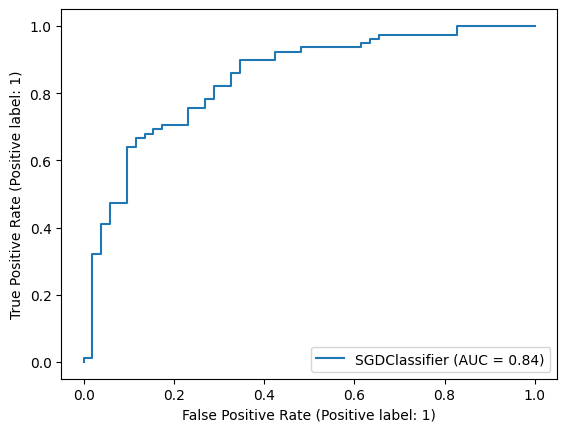

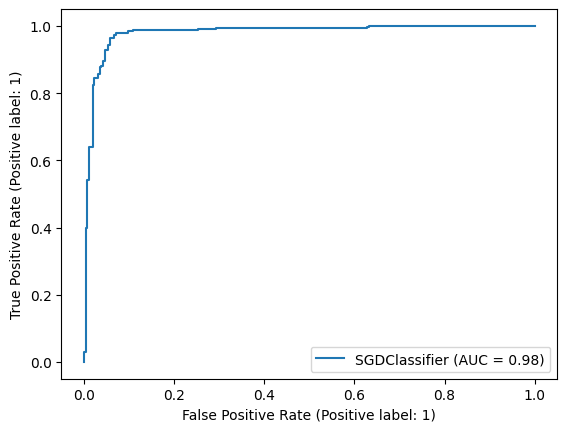

In [83]:
class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, random_state=1)

rand_clusters = np.ones((1, 4005))

#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
x_train2 = np.concatenate([x_train * c for c in rand_clusters], axis=1)
x_test2 = np.concatenate([x_test * c for c in rand_clusters], axis=1)
inputs2 = np.concatenate([inputs * c for c in rand_clusters], axis=1)

class_model2.fit(x_train2, y_train)

auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, y_test, ax=None)
tot_auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              inputs2, labels, ax=None)

auc_data.roc_auc

0.881163708086785

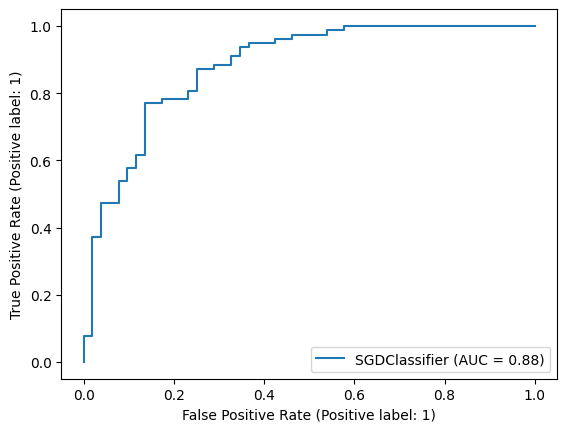

In [84]:
class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.001, random_state=1)

#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
x_train2 = np.mean([x_train * c for c in unsup_model.cluster_centers_], axis=0)
x_test2 = np.mean([x_test * c for c in unsup_model.cluster_centers_], axis=0)
inputs2 = np.mean([inputs * c for c in unsup_model.cluster_centers_], axis=0)

class_model2.fit(x_train2, y_train)

auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, y_test, ax=None)

auc_data.roc_auc

(0.8917652859960552, 0.8076923076923077)

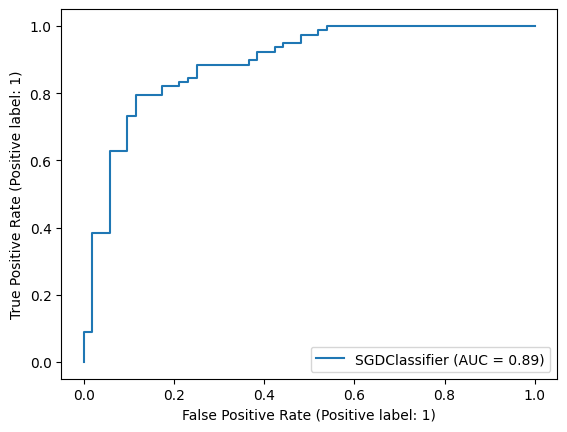

In [161]:
class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.01, random_state=1)

#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
x_train2 = np.concatenate([x_train * np.abs(c) for c in unsup_model.cluster_centers_], axis=1)
x_test2 = np.concatenate([x_test * np.abs(c) for c in unsup_model.cluster_centers_], axis=1)
inputs2 = np.concatenate([inputs * np.abs(c) for c in unsup_model.cluster_centers_], axis=1)

class_model2.fit(x_train2, y_train)

auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, y_test, ax=None)

auc_data.roc_auc, class_model2.score(x_test2, y_test)

(0.8964497041420119, 0.8307692307692308)

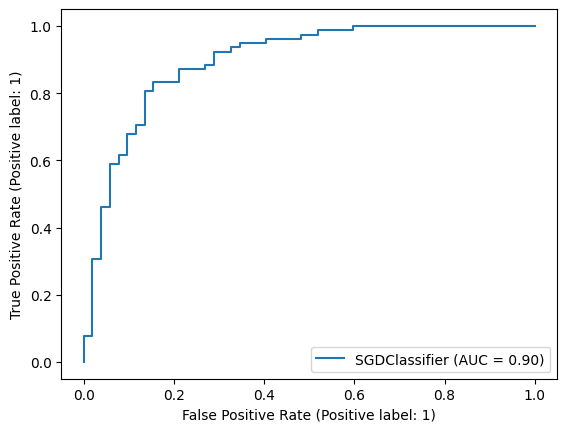

In [158]:
class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.002, random_state=1)
bt = lambda x: hv.threshold(x, 0.8)
#class_model.fit(get_clusters(unsup_model, x_train, n), y_train)
x_train2 = np.concatenate([x_train * bt(unsup_model.cluster_centers_[0])], axis=1)
x_test2 = np.concatenate([x_test * bt(unsup_model.cluster_centers_[0])], axis=1)
inputs2 = np.concatenate([inputs * bt(unsup_model.cluster_centers_[0])], axis=1)

class_model2.fit(x_train2, y_train)

auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, y_test, ax=None)

auc_data.roc_auc, class_model2.score(x_test2, y_test)

In [124]:
from sklearn.model_selection import StratifiedKFold

 Training model unsup, fold 9/10

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/_plotting.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'nn model')]

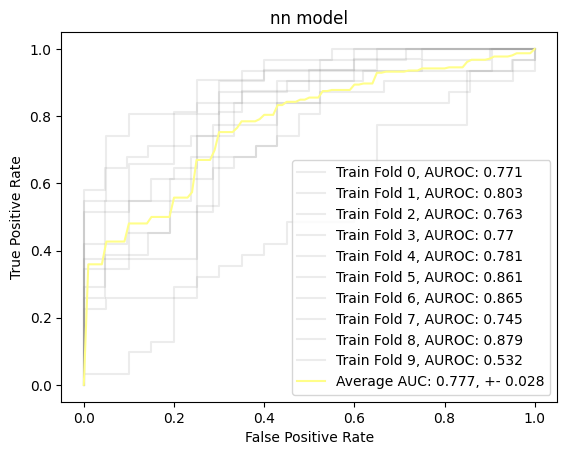

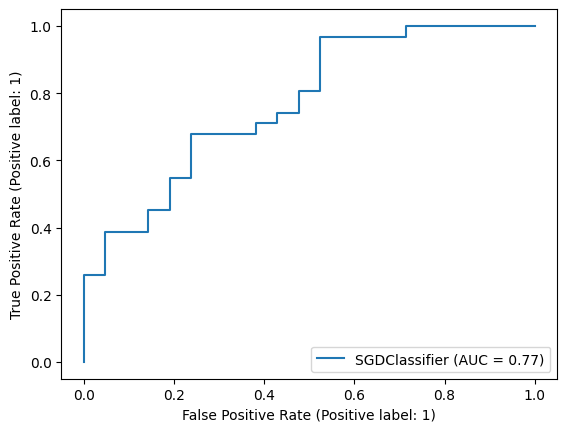

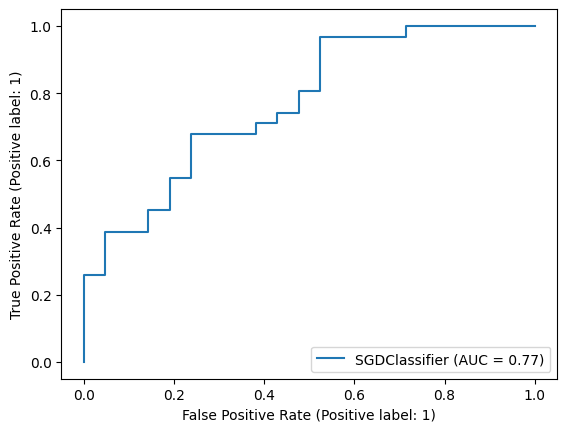

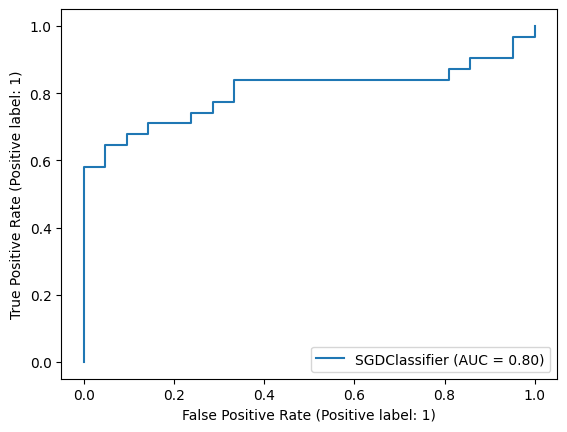

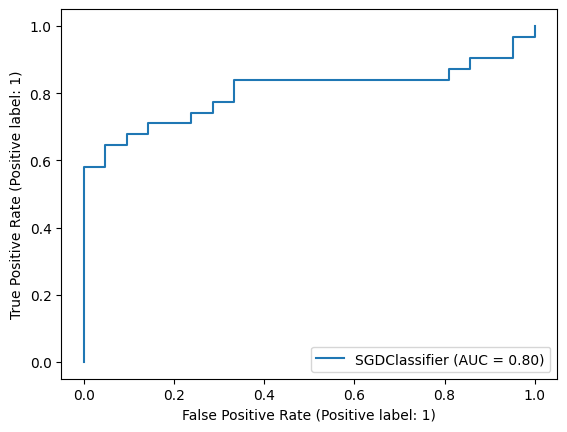

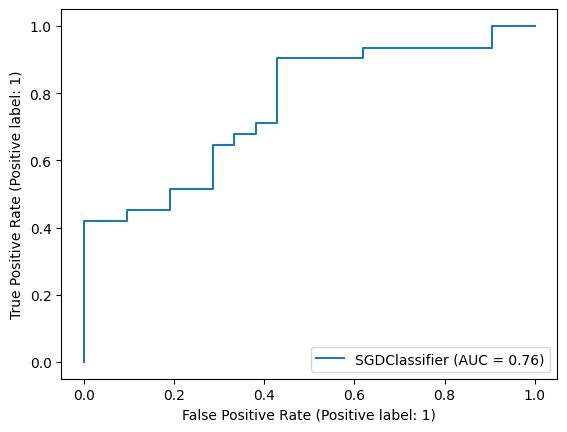

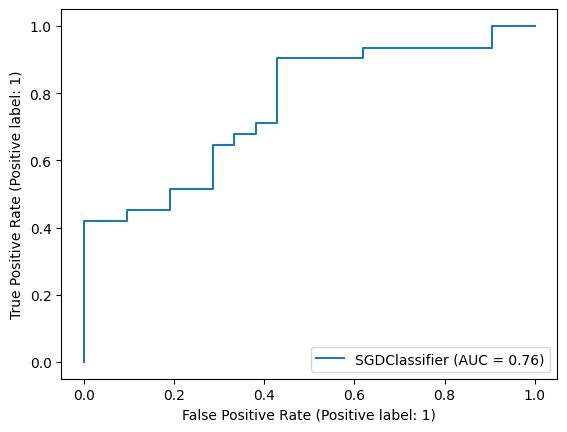

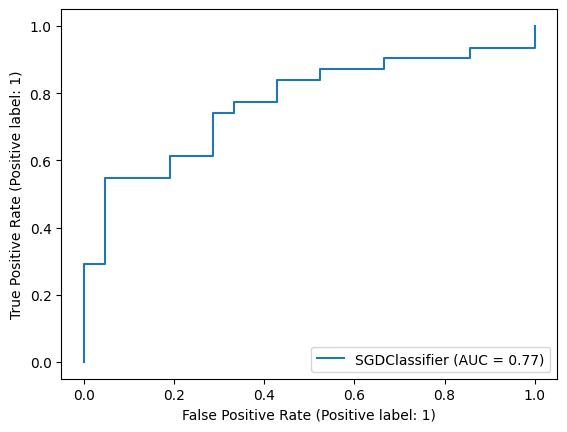

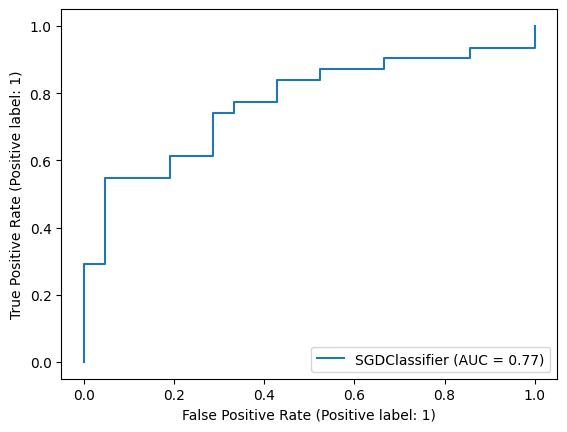

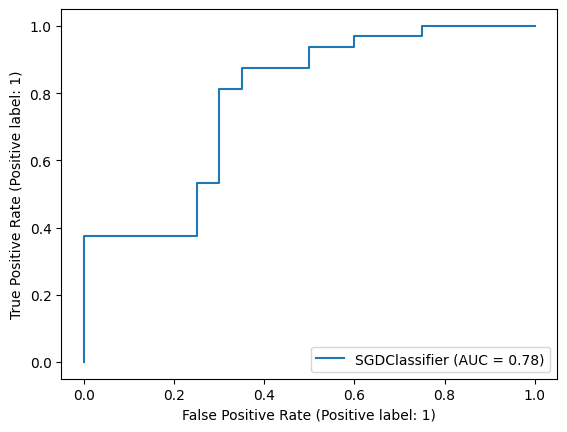

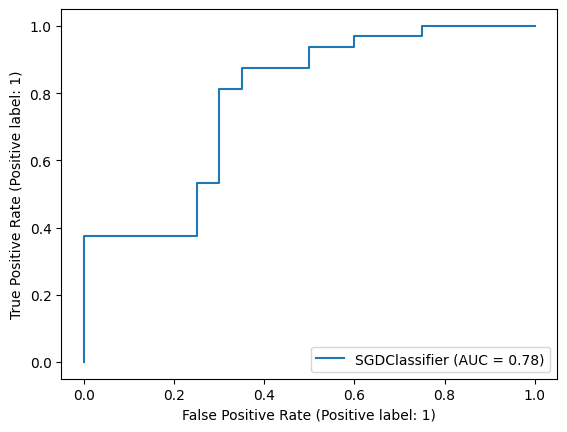

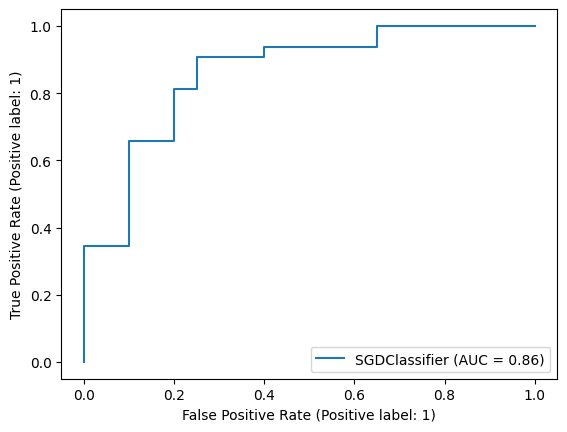

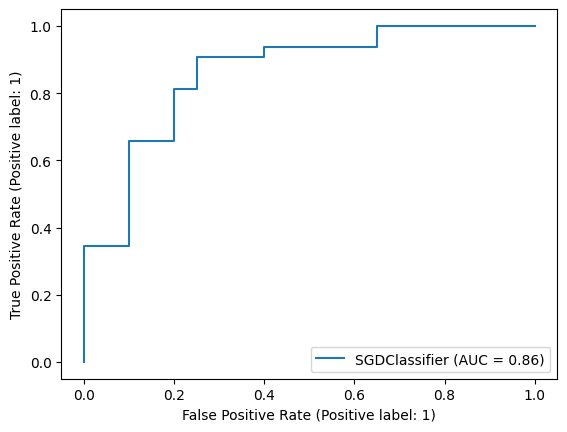

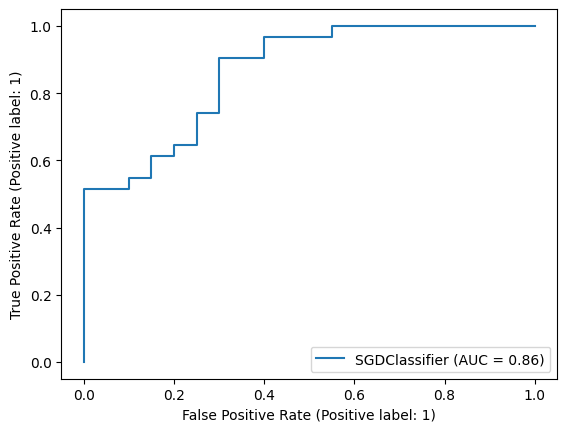

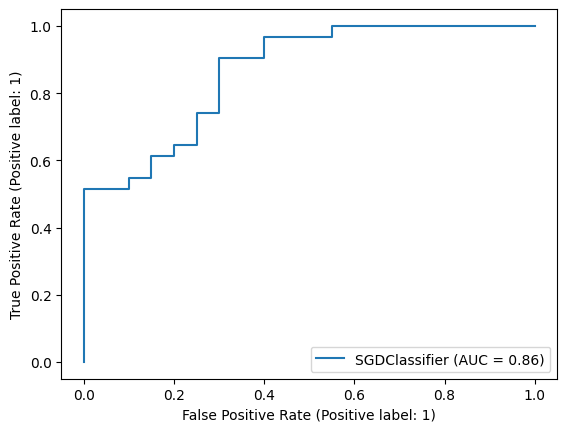

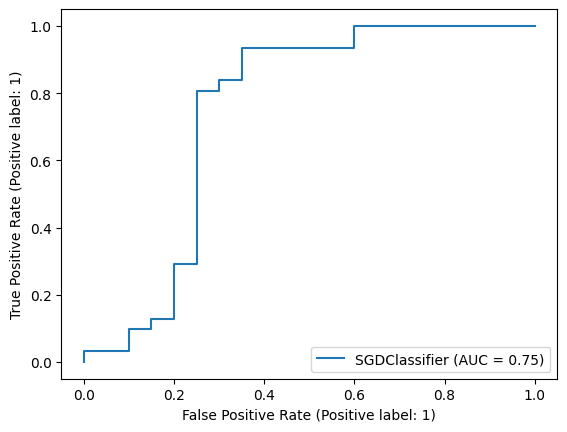

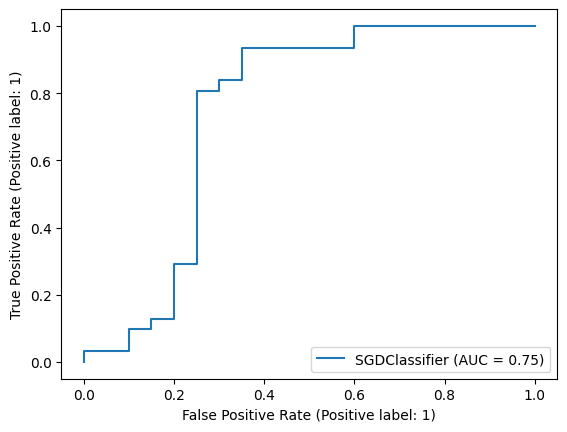

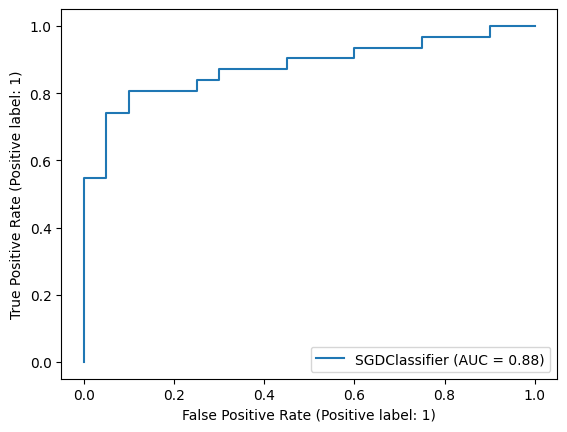

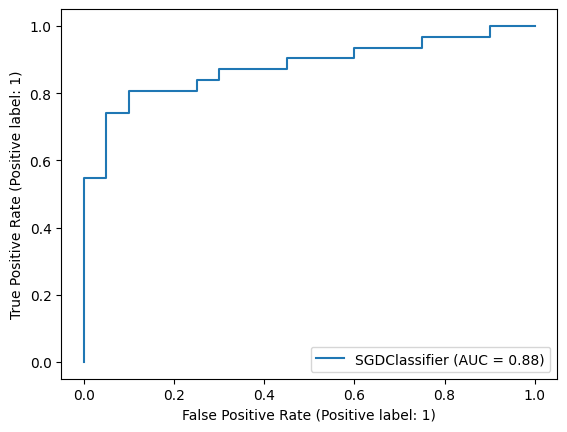

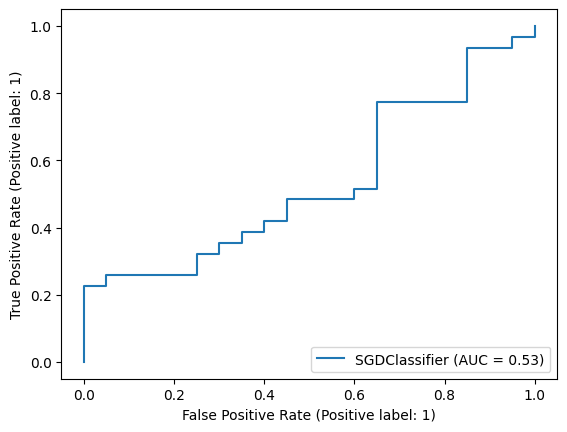

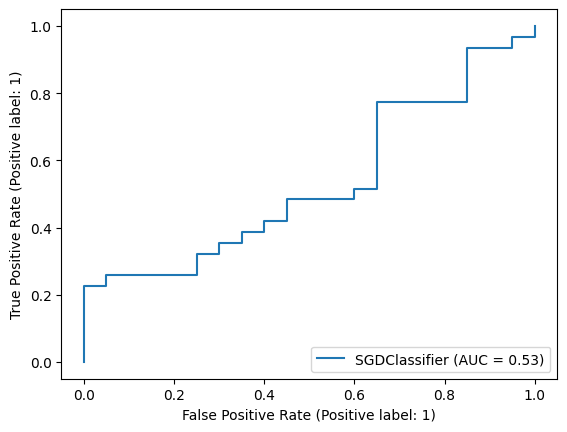

In [137]:
fig, ax = plt.subplots()
unsup_model2 = sklearn.cluster.KMeans(2, n_init=10, random_state=1)

out_metrics = {}
folds = 10
tprs = []
base_fpr = np.linspace(0, 1, 101)
skf = uu.StratifiedKFold(folds)

for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    out_metrics[j] = {}
    
    class_model2 = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.002, random_state=1)

    fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]
    
    unsup_model2.fit(fold_x_train)
    
    bt = lambda x: hv.threshold(x, 0.8)
    x_train2 = np.concatenate([fold_x_train * bt(unsup_model.cluster_centers_[0])], axis=1)
    x_test2 = np.concatenate([fold_x_test * bt(unsup_model.cluster_centers_[0])], axis=1)
    
    class_model2.fit(x_train2, fold_y_train)

    auc_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, 
                                                              x_test2, fold_y_test, ax=None)
    
    out_metrics[j]["acc"] = class_model2.score(x_test2, fold_y_test)

    viz_data = sklearn.metrics.RocCurveDisplay.from_estimator(class_model2, x_test2, fold_y_test)
    fpr = viz_data.fpr
    tpr = viz_data.tpr
    
    out_metrics[j]["auc"] = viz_data.roc_auc

    roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(viz_data.roc_auc, 3)}")
    out_metrics[j]["roc_plot"] = roc

    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    #print(f"Training model {model_name}, fold {j}/{folds} prop 1 train: {fold_y_train.mean()}, prop 1  test: {fold_y_test.mean()}")
    print("\r", f"Training model unsup, fold {j}/{folds}", end="")

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)

aucs = [m['auc'] for _, m in out_metrics.items()]
mean_auc = np.mean(aucs)
sd_auc = np.std(aucs)

ci = 0.95 * sd_auc / np.sqrt(len(aucs))

ax.plot(base_fpr, mean_tprs, color="#FFFE89", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="nn model")


[Text(0.5, 1.0, 'multiplied unsup model weights')]

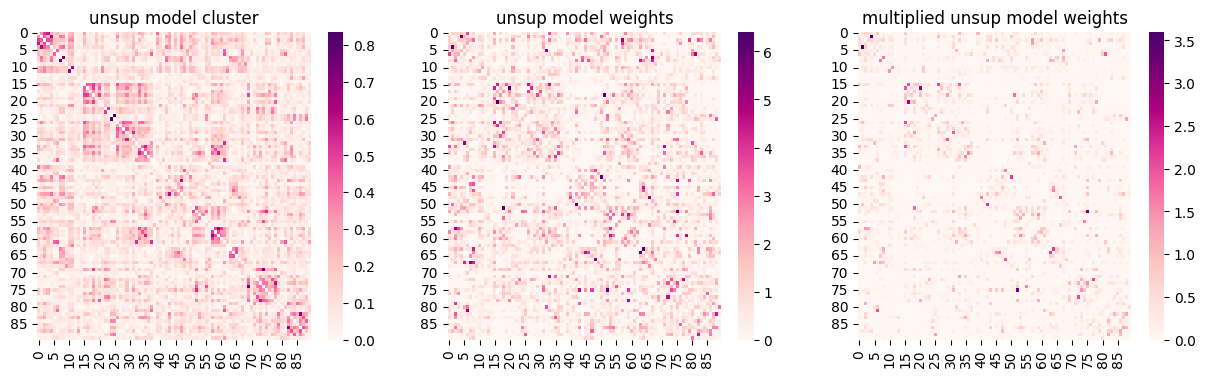

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(hv.convert_triangle_to_mat(np.abs(unsup_model.cluster_centers_[0])), cmap="RdPu", ax=ax[0])
sns.heatmap(hv.convert_triangle_to_mat(np.abs(class_model2.coef_[0])), cmap="RdPu", ax=ax[1])
sns.heatmap(hv.convert_triangle_to_mat(np.abs(unsup_model.cluster_centers_[0]*class_model2.coef_[0])), 
            cmap="RdPu", ax=ax[2])


ax[0].set(title="unsup model cluster")
ax[1].set(title="unsup model weights")
ax[2].set(title="multiplied unsup model weights")



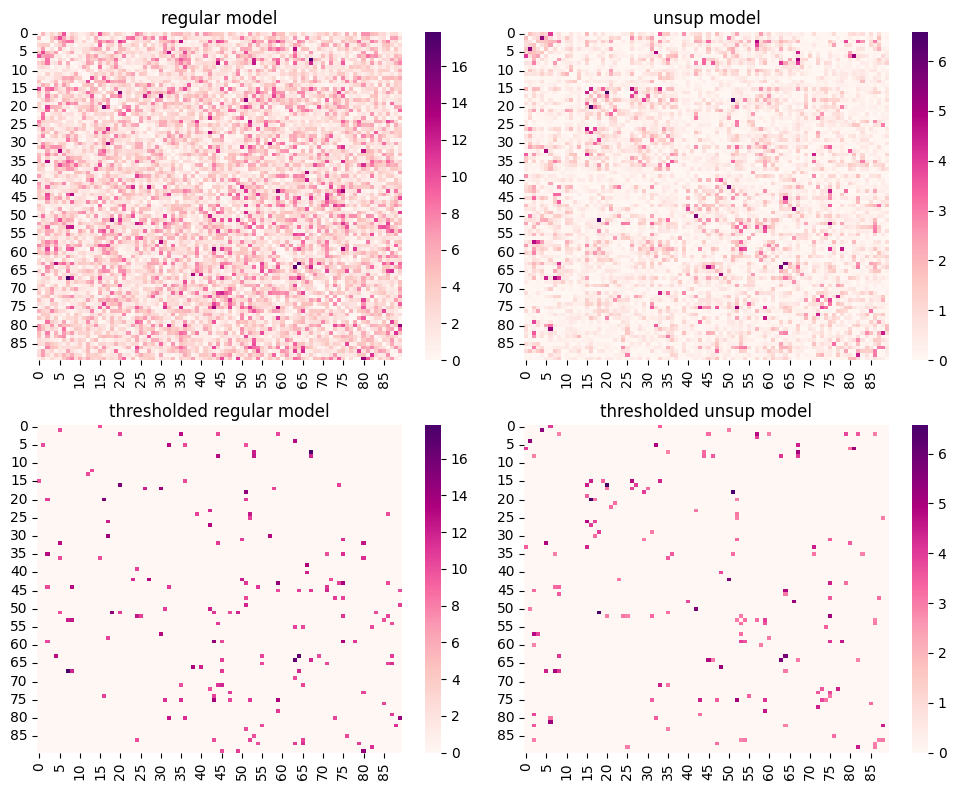

In [88]:
model = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.0001, random_state=1)
model.fit(x_train, y_train)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
sns.heatmap(hv.convert_triangle_to_mat(np.abs(model.coef_[0])), cmap="RdPu", ax=ax[0, 0])
sns.heatmap(hv.convert_triangle_to_mat(np.abs(class_model2.coef_[0])), cmap="RdPu", ax=ax[0, 1])

ax[0, 0].set(title="regular model")
ax[0, 1].set(title="unsup model")

sns.heatmap(hv.threshold(hv.convert_triangle_to_mat(np.abs(model.coef_[0]))), cmap="RdPu", ax=ax[1, 0])
sns.heatmap(hv.threshold(hv.convert_triangle_to_mat(np.abs(class_model2.coef_[0]))), cmap="RdPu", ax=ax[1, 1])

ax[1, 0].set(title="thresholded regular model")
ax[1, 1].set(title="thresholded unsup model")

fig.tight_layout()

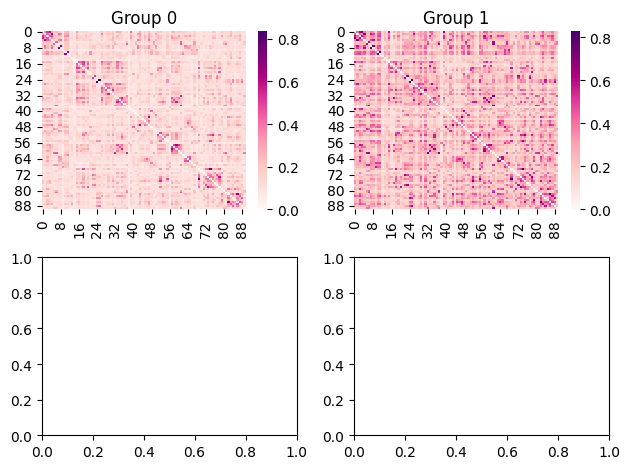

In [90]:
dp = int(np.ceil(np.sqrt(n)))


fig, ax = plt.subplots(dp, dp)

for i in range(n):
    sns.heatmap(hv.convert_triangle_to_mat(np.mean(np.abs(in_clusters[i]), axis=0)), ax=ax[i//dp, i%dp], cmap="RdPu")
    ax[i//dp, i%dp].set(title=f"Group {i}")

fig.tight_layout()

In [1006]:
inputs[labels==0].shape

(256, 4005)

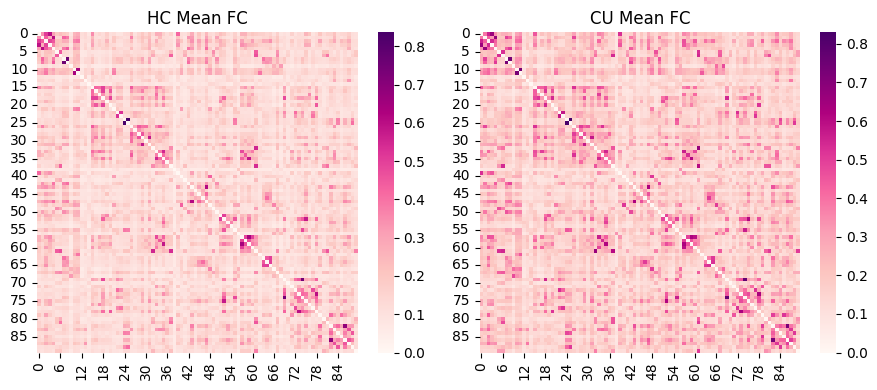

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(hv.convert_triangle_to_mat(np.mean(np.abs(inputs[labels == 0]), axis=0)), cmap="RdPu", ax = ax[0])
sns.heatmap(hv.convert_triangle_to_mat(np.mean(np.abs(inputs[labels == 1]), axis=0)), cmap="RdPu", ax = ax[1])

ax[0].set(title="HC Mean FC")
ax[1].set(title="CU Mean FC")

fig.tight_layout()

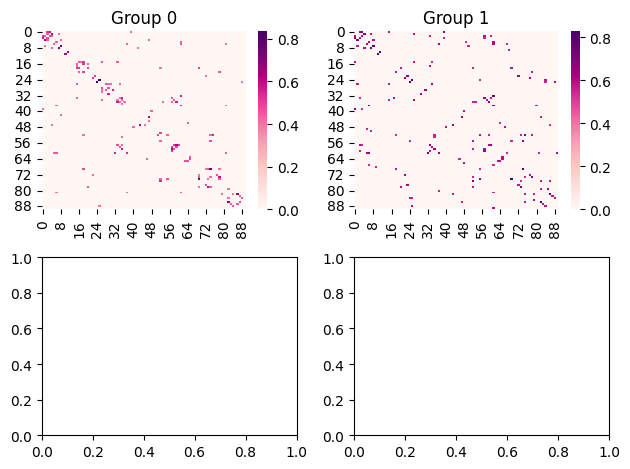

In [777]:
dp = int(np.ceil(np.sqrt(n)))


fig, ax = plt.subplots(dp, dp)

for i in range(n):
    sns.heatmap(hv.threshold(hv.convert_triangle_to_mat(np.mean(np.abs(in_clusters[i]), axis=0))), ax=ax[i//dp, i%dp], cmap="RdPu")
    ax[i//dp, i%dp].set(title=f"Group {i}")

fig.tight_layout()

In [89]:
class_model.coef_

array([[ 3.35845052, -3.20399575]])

In [327]:
np.mean(np.array(clustered == 1, dtype=np.int) == 1-np.array(in_labels, dtype=np.int))

/var/folders/24/mpw62vn54110sf_ggs3n3ry40000gn/T/ipykernel_57975/3033825756.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.mean(np.array(clustered == 1, dtype=np.int) == 1-np.array(in_labels, dtype=np.int))


0.5975232198142415

# Clustering Of Each Group

In [306]:
n = 4
unsup_model_cu = sklearn.cluster.KMeans(n_clusters=n, n_init=10)

unsup_model_cu.fit(x_train[y_train == 1])

KMeans(n_clusters=4, n_init=10)

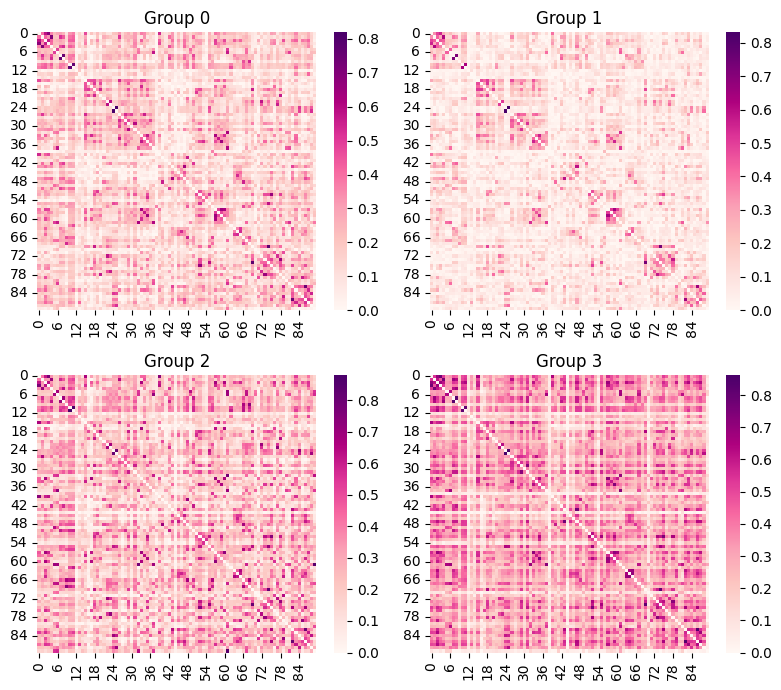

In [307]:
dp = int(np.ceil(np.sqrt(n)))


fig, ax = plt.subplots(dp, dp, figsize=(8, 7))

for i in range(n):
    sns.heatmap(hv.convert_triangle_to_mat(np.abs(unsup_model_cu.cluster_centers_[i])), 
                ax=ax[i//dp, i%dp], cmap="RdPu")
    ax[i//dp, i%dp].set(title=f"Group {i}")

fig.tight_layout()

In [308]:
n = 4
unsup_model_hc = sklearn.cluster.KMeans(n_clusters=n, n_init=10)

unsup_model_hc.fit(x_train[y_train == 0])

KMeans(n_clusters=4, n_init=10)

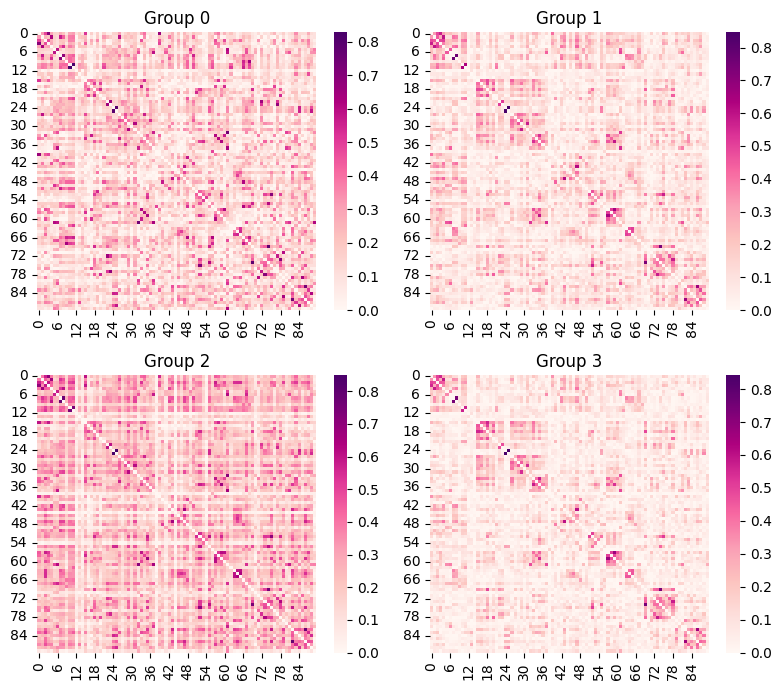

In [309]:
dp = int(np.ceil(np.sqrt(n)))


fig, ax = plt.subplots(dp, dp, figsize=(8, 7))
for i in range(n):
    sns.heatmap(hv.convert_triangle_to_mat(np.abs(unsup_model_hc.cluster_centers_[i])), 
                ax=ax[i//dp, i%dp], cmap="RdPu")
    ax[i//dp, i%dp].set(title=f"Group {i}")

fig.tight_layout()

<Axes: >

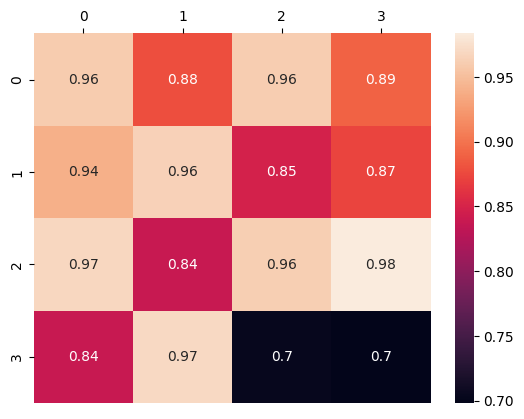

In [310]:
fig, ax = plt.subplots()
a = np.zeros((n, n))
ax.xaxis.tick_top()
scoring = hv.cosim
for i in range(n):
    for j in range(n):
        a[i, j] = scoring(unsup_model_hc.cluster_centers_[i], unsup_model_cu.cluster_centers_[j])
    #a[i] = a[i][np.argsort(a[i])]

sns.heatmap(a, annot=True)

In [312]:
import itertools

def rwo(n, *x):
    rang = list(range(n))
    for i in x:
        rang.remove(i)
    
    return rang

def unjumble(x):
    max_score = -1
    max_rs = []
    
    for r1 in range(n):
        for r2 in rwo(n, r1):
            for r3 in rwo(n, r1, r2):
                for r4 in rwo(n, r1, r2, r3):
                    s = x[0, r1] * x[1, r2] * x[2, r3] * x[3, r4]
                    if s > max_score:
                        max_score = s
                        max_rs = [r1, r2, r3, r4]     
    max_rs = np.array(max_rs)
    return x[:, max_rs], max_rs
        

In [313]:
unjumble(a)

(array([[0.96121856, 0.95902141, 0.88984675, 0.87789259],
        [0.8481904 , 0.93969262, 0.87302581, 0.96384243],
        [0.96163621, 0.96855669, 0.98354195, 0.83766022],
        [0.7031558 , 0.83816049, 0.69807396, 0.96913608]]),
 array([2, 0, 3, 1]))

<Axes: >

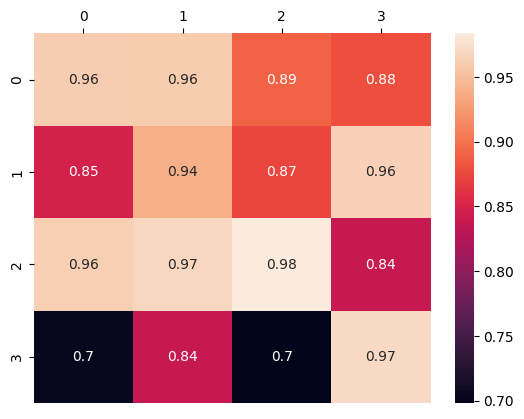

In [314]:
fig, ax = plt.subplots()
ax.xaxis.tick_top()
sns.heatmap(unjumble(a)[0], annot=True)

In [321]:
pd.Series(unsup_model_cu.predict(inputs)).value_counts()

1    343
0    187
2     74
3     42
Name: count, dtype: int64

# PCA

In [265]:
x_train.shape

(516, 4005)

In [300]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dims = 8

In [301]:
scaler = StandardScaler()
pca = PCA(n_components=dims)

scaler.fit(x_train)
pca.fit(scaler.transform(x_train))

x_train_pca = pca.transform(scaler.transform(x_train))
x_test_pca = pca.transform(scaler.transform(x_test))

In [302]:
model_pca = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.02)
model_pca.fit(x_train_pca, y_train)

SGDClassifier(alpha=0.02)

In [303]:
np.round(pca.explained_variance_/np.sum(pca.explained_variance_) * 100, 2)

array([60.62, 12.31,  8.09,  4.51,  4.19,  3.75,  3.47,  3.08])

In [305]:
pca.__dict__

{'n_components': 8,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'n_features_in_': 4005,
 '_fit_svd_solver': 'randomized',
 'mean_': array([-2.12394701e-15, -3.04773433e-15,  4.44205194e-15, ...,
         1.17046768e-16, -4.73350902e-17,  9.25185854e-17]),
 'n_samples_': 516,
 'components_': array([[ 0.01206281,  0.01542843,  0.01881485, ...,  0.01103046,
         -0.01023065, -0.01337185],
        [ 0.01597733,  0.00931983, -0.01484958, ...,  0.00599738,
          0.01584597,  0.02084457],
        [-0.02418152, -0.01884731, -0.00127278, ..., -0.02694222,
          0.00605577, -0.00703173],
        ...,
        [-0.01350708, -0.00141897,  0.00249341, ...,  0.01239078,
          0.03184857,  0.02757885],
        [-0.00693823, -0.0121624 , -0.00017412, ...,  0.01896384,
          0.03727161,  0.03975274],
        [ 0.01565402,  0.01636472,  0.03316052, .

0.7247674710910006

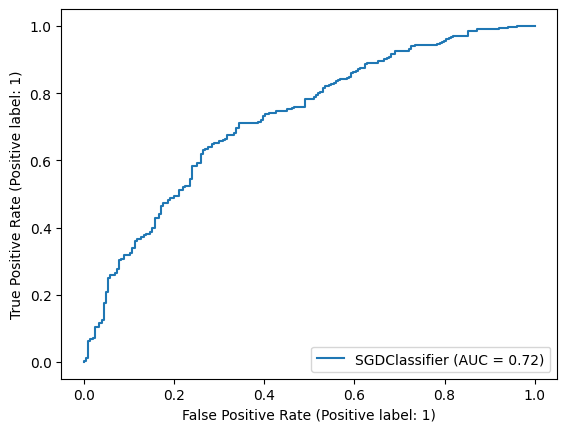

In [304]:
sklearn.metrics.RocCurveDisplay.from_estimator(model_pca, x_train_pca, y_train, ax=None).roc_auc

0.525887573964497

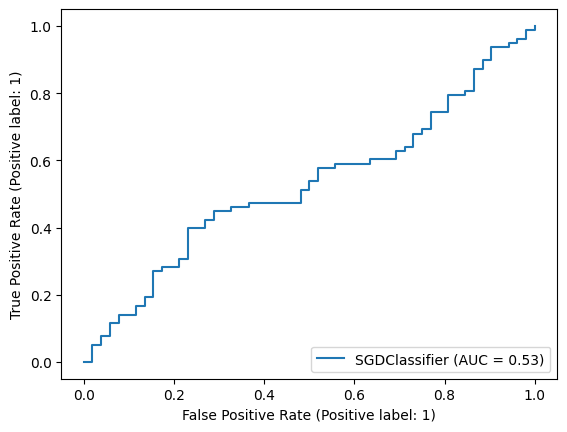

In [289]:
sklearn.metrics.RocCurveDisplay.from_estimator(model_pca, x_test_pca, y_test).roc_auc

SelectPercentile()

# Ordinary Least Squares

In [327]:
import sklearn.cross_decomposition

([<matplotlib.axis.XTick at 0x7f9f62c51310>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

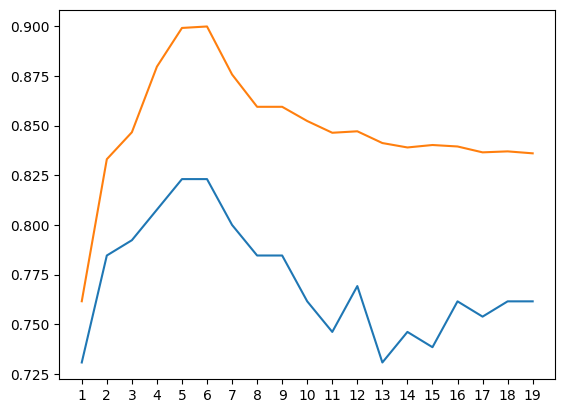

In [391]:
accs = []
aucs = []
comps = []
for components in range(1, 20):
    pls = sklearn.cross_decomposition.PLSRegression(components)
    pls.fit(x_train, y_train)

    acc = np.mean(np.round(pls.predict(x_test))[:, 0] == y_test)
    auc = sklearn.metrics.roc_auc_score(y_test, pls.predict(x_test)[:, 0])

    accs.append(acc)
    aucs.append(auc)
    comps.append(components)

plt.plot(comps, accs)
plt.plot(comps, aucs)
plt.xticks(comps)

In [456]:
pls = sklearn.cross_decomposition.PLSRegression(5)
pls.fit(x_train, y_train)

acc = np.mean(np.round(pls.predict(x_test))[:, 0] == y_test)
auc = sklearn.metrics.roc_auc_score(y_test, pls.predict(x_test)[:, 0])

acc, auc

(0.823076923076923, 0.8991617357001973)

In [457]:
pls.x_weights_.shape

(4005, 5)

In [458]:
pls.coef_.shape

(1, 4005)

In [500]:
pls.y_weights_

array([[ 0.01264429, -0.08072555, -0.04644778, -0.04242767,  0.04074689]])

In [521]:
pc1 = pls.x_weights_[:, 2]
pc1[np.argsort(pc1)]

array([-0.046645  , -0.0464172 , -0.04633818, ...,  0.04331498,
        0.04433246,  0.05142769])

In [522]:
thresh
indices = np.argsort(np.abs(pc1))[::-1][:int(4005*thresh)]
pc1[indices]

array([ 0.05142769, -0.046645  , -0.0464172 , -0.04633818, -0.04617447,
       -0.04592117, -0.0453402 , -0.04472544, -0.04450242,  0.04433246,
       -0.0442509 , -0.04407091, -0.0440129 , -0.04341343,  0.04331498,
        0.04328599,  0.04294583,  0.04289471, -0.04284418, -0.04276261,
        0.04275783, -0.04274132, -0.04240929,  0.04239583, -0.0422502 ,
       -0.04212727, -0.04203069,  0.04154193, -0.04066946, -0.04039672,
       -0.04031033, -0.04030748, -0.04011509, -0.03985842, -0.03963128,
       -0.03956453, -0.03949613,  0.03949214, -0.03937526, -0.03933174,
        0.03929467,  0.03927863, -0.03921268,  0.03904867,  0.03901949,
        0.03896118,  0.03868506, -0.03864926,  0.03840226, -0.03828137,
       -0.03824867, -0.03824865, -0.03806037, -0.03801608, -0.03795857,
        0.03789415,  0.03788047, -0.03774965, -0.0374836 ,  0.03742792,
        0.03732733, -0.03727801, -0.0372275 , -0.03710056,  0.03708887,
       -0.03707343, -0.03682782, -0.03681184, -0.03667948, -0.03

In [523]:
indices

array([2721, 1633, 2909, 1351, 2209, 1333, 3684, 1494, 3689, 2701, 2131,
       1870, 2026, 3249, 1307,  550, 2357, 2085, 1657, 3226, 2117, 1934,
       1278, 1246, 2886,  402, 3081, 2056,  952, 1834, 2149,  704, 2729,
       1352,  963, 2304,  885, 1873, 2171, 3108, 1937,  539, 3693, 1760,
        661, 1702,  542, 3086, 1086, 1260, 1951,  564,  874, 1476, 2088,
       2804, 1842,  144, 2326, 1664, 1772,  739, 1518,  750, 2803, 2070,
        886, 3679,  702, 2187, 2113,  753, 3252, 1519,  683, 1663, 1706,
        864, 2796, 2476, 1887, 1161,  552, 2163, 3129, 2533,  467,  971,
       2191, 1375, 1376, 3856,  950, 2955,  939,  893,  891,  658,  174,
       1653, 2627,  538, 1700, 1742, 1303, 3982,  964, 1955, 2236,  790,
       3814,  404, 3782, 2912,  118,  456,  748,  825, 3274,  706, 1859,
        378, 1319, 1391, 2061,  749, 3698, 3457, 3189,  691,  938,  266,
       3940,  625, 3233, 3248, 2167, 1207,  764, 1379, 2784,  741, 1275,
        861,  380,  527, 1634, 2800,  672, 3339, 29

<Axes: >

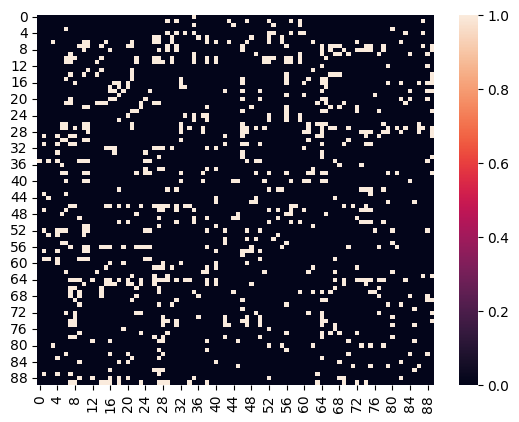

In [528]:
def get_selected_features(indices):
    a = np.zeros((90, 90))
    c = 0
    for i in range(90):
        for j in range(i+1, 90):
            a[i, j] = 1 if c in indices else 0
            c += 1
    a = a.T
    c = 0
    for i in range(90):
        for j in range(i+1, 90):
            a[i, j] = 1 if c in indices else 0
            c += 1
    a = a.T
    return a

a = get_selected_features(indices)

sns.heatmap(a)

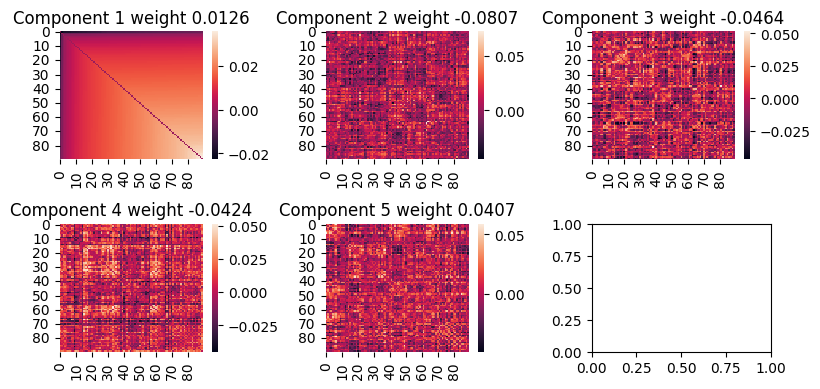

In [545]:
dw = int(np.ceil(np.sqrt(pls.x_weights_.shape[1])))
dh = int(np.ceil(pls.x_weights_.shape[1]/dw))
fig, ax = plt.subplots(dh, dw, figsize=(8, 4))
for i in range(pls.x_weights_.shape[1]):
    pc = pls.x_weights_[:, i]
    sns.heatmap(hv.convert_triangle_to_mat(pc), ax=ax[i//dw, i%dw])
    
    ax[i//dw, i%dw].set(title=f"Component {i+1} weight {np.round(pls.y_weights_[0, i], 4)}")
    
fig.tight_layout()


In [629]:
(np.argmax(pls.x_scores_, axis=1) == 3).sum()

89

In [546]:
from sklearn.decomposition import PCA

In [550]:
pls.x_weights_.shape

(4005, 5)

In [602]:
pls._x_scores.shape

(516, 5)

In [604]:
pcs = []
for weights in range(pls.x_weights_.shape[1]):
    pc = pls.x_scores_[:, weights]#(x_train * pls.x_weights_[:, weights]).sum(axis=1)
    pcs.append(pc)

pcs = np.stack(pcs, axis=1)
pcs.shape

(516, 5)

In [779]:
pcs = pls.transform(x_train)
pcs.shape

(516, 5)

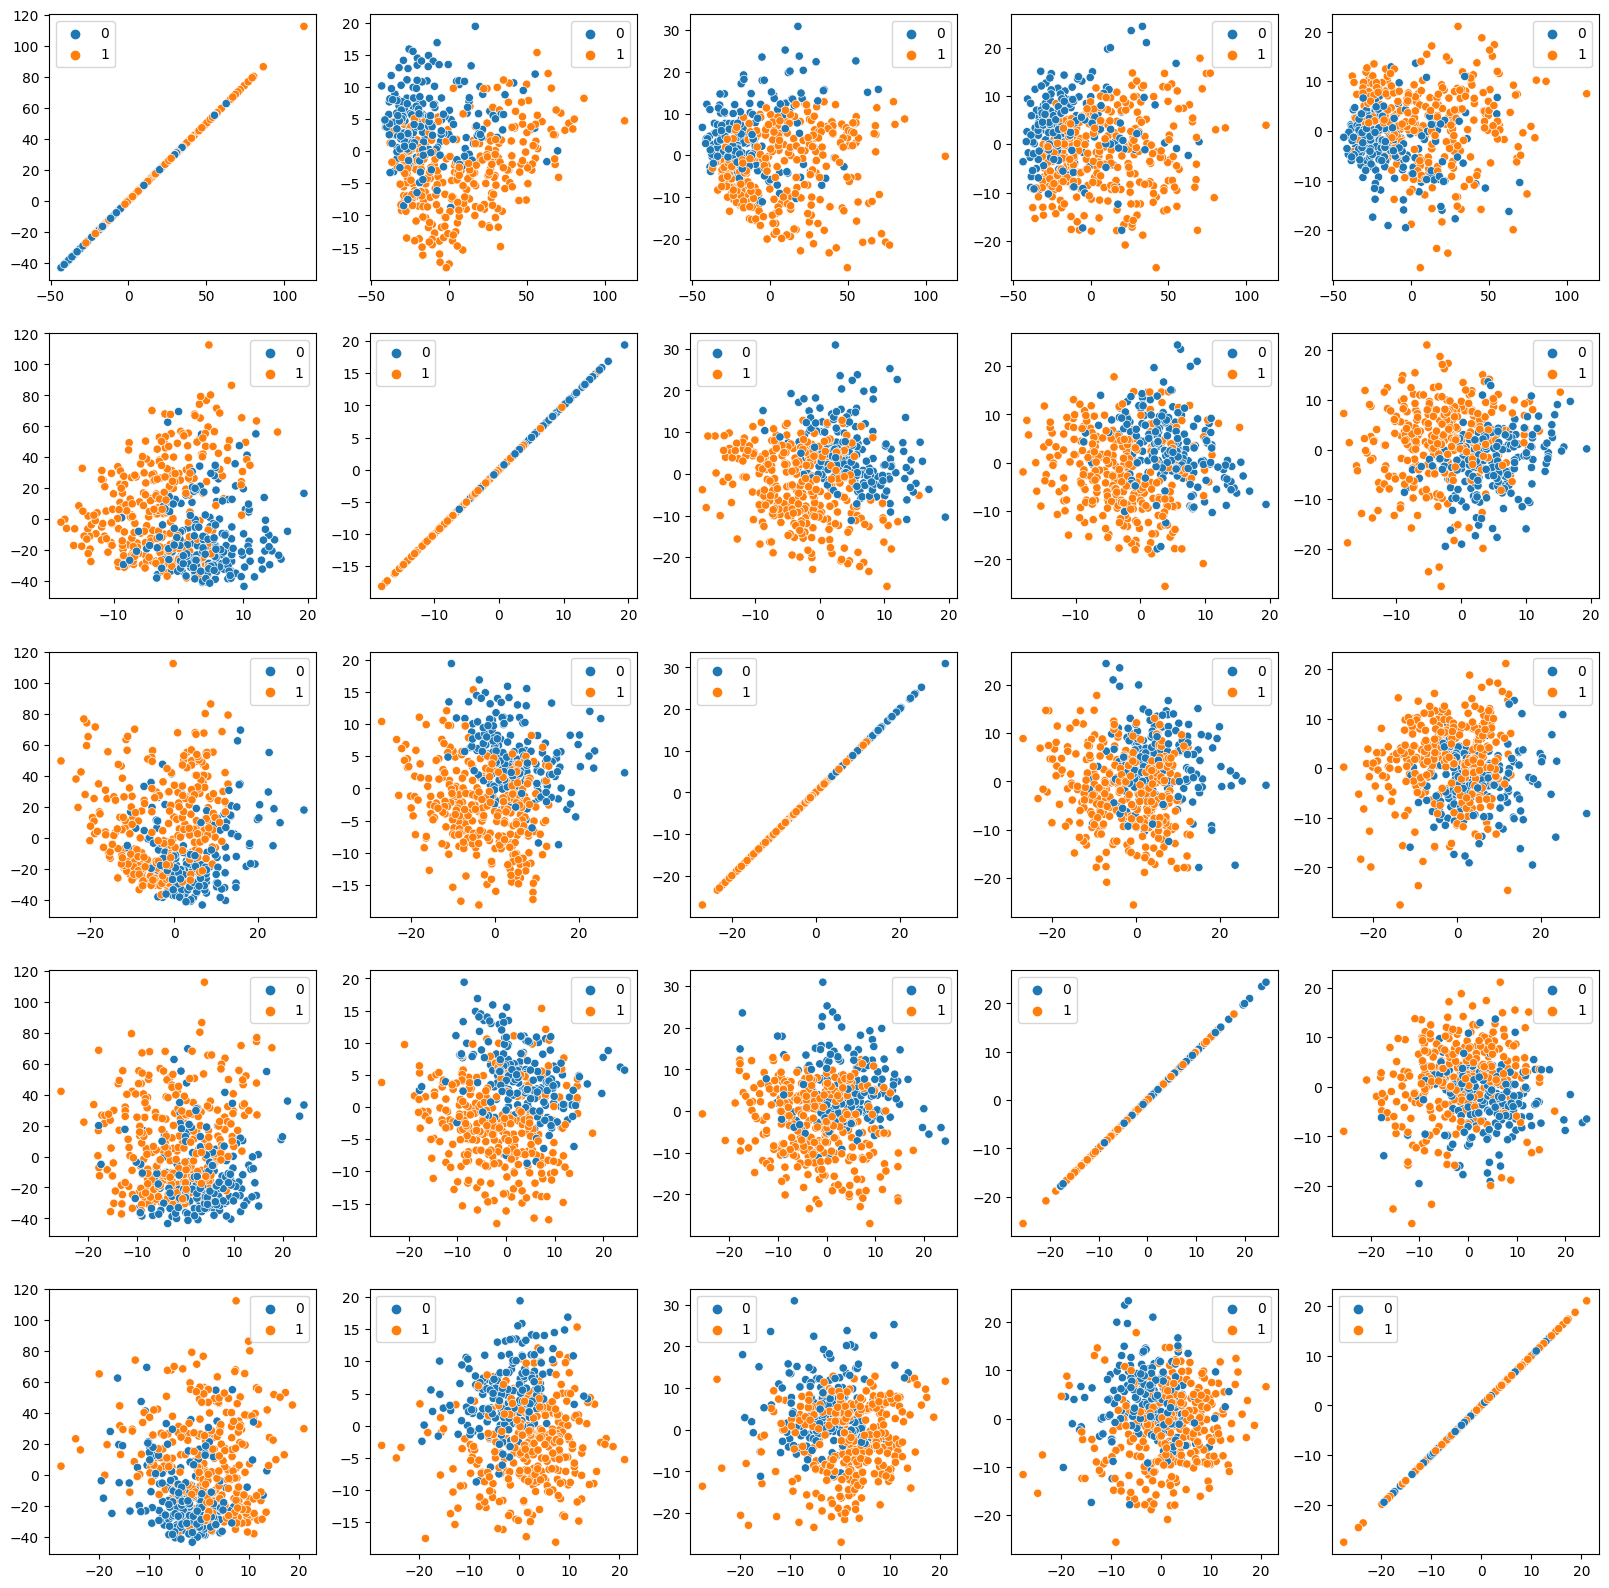

In [853]:
pcs = pls.transform(x_train)

n = pls.x_scores_.shape[1]
fig, ax = plt.subplots(n, n, figsize=(20, 20))

for i in range(n):
    for j in range(n):
        sns.scatterplot(x=pcs[:, i], y=pcs[:, j], hue=y_train, ax=ax[i, j])

In [777]:
3/130 * 100

2.307692307692308

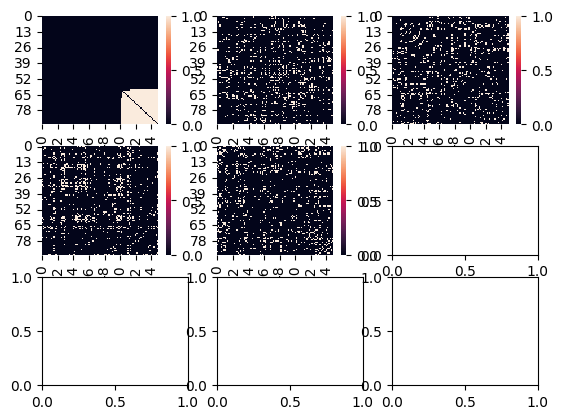

In [606]:
# dq = int(np.ceil(np.sqrt(pls.x_weights_.shape[1])))
fig, ax = plt.subplots(dq, dq)
for i in range(pls.x_weights_.shape[1]):
    pc = pls.x_weights_[:, i]
    indices = np.argsort(np.abs(pc))[::-1][:int(4005*thresh)]
    
    sns.heatmap(get_selected_features(indices), ax=ax[i//dq, i%dq])

In [525]:
indices

array([2721, 1633, 2909, 1351, 2209, 1333, 3684, 1494, 3689, 2701, 2131,
       1870, 2026, 3249, 1307,  550, 2357, 2085, 1657, 3226, 2117, 1934,
       1278, 1246, 2886,  402, 3081, 2056,  952, 1834, 2149,  704, 2729,
       1352,  963, 2304,  885, 1873, 2171, 3108, 1937,  539, 3693, 1760,
        661, 1702,  542, 3086, 1086, 1260, 1951,  564,  874, 1476, 2088,
       2804, 1842,  144, 2326, 1664, 1772,  739, 1518,  750, 2803, 2070,
        886, 3679,  702, 2187, 2113,  753, 3252, 1519,  683, 1663, 1706,
        864, 2796, 2476, 1887, 1161,  552, 2163, 3129, 2533,  467,  971,
       2191, 1375, 1376, 3856,  950, 2955,  939,  893,  891,  658,  174,
       1653, 2627,  538, 1700, 1742, 1303, 3982,  964, 1955, 2236,  790,
       3814,  404, 3782, 2912,  118,  456,  748,  825, 3274,  706, 1859,
        378, 1319, 1391, 2061,  749, 3698, 3457, 3189,  691,  938,  266,
       3940,  625, 3233, 3248, 2167, 1207,  764, 1379, 2784,  741, 1275,
        861,  380,  527, 1634, 2800,  672, 3339, 29

In [526]:
np.square(pc1).sum()

1.0

In [483]:
(x_train * pc1).sum(axis=1).shape

(516,)

In [487]:
import scipy.stats

array([ 0.35887309,  0.47148087,  0.61324008, ...,  0.35021882,
       -0.24843994, -0.28862341])

<Axes: >

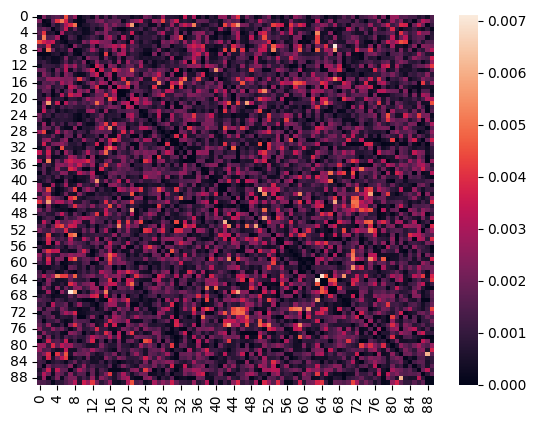

In [460]:
sns.heatmap(np.abs(hv.convert_triangle_to_mat(pls.coef_[0])))

In [461]:
from sklearn.calibration import CalibratedClassifierCV
class_weight=None
m = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.0001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_svm = CalibratedClassifierCV(m, cv=5, ensemble=False)
model_l1_svm

CalibratedClassifierCV(cv=5, ensemble=False,
                       estimator=SGDClassifier(max_iter=1000000, penalty='l1',
                                               random_state=1))

In [462]:
m.fit(x_train, y_train)

SGDClassifier(max_iter=1000000, penalty='l1', random_state=1)

In [463]:
model_l1_svm.fit(x_train, y_train)

CalibratedClassifierCV(cv=5, ensemble=False,
                       estimator=SGDClassifier(max_iter=1000000, penalty='l1',
                                               random_state=1))

In [464]:
model_l1_svm.__dict__

{'estimator': SGDClassifier(max_iter=1000000, penalty='l1', random_state=1),
 'method': 'sigmoid',
 'cv': 5,
 'n_jobs': None,
 'ensemble': False,
 'base_estimator': 'deprecated',
 'calibrated_classifiers_': [<sklearn.calibration._CalibratedClassifier at 0x7f9f62ce9430>],
 'classes_': array([0, 1]),
 'n_features_in_': 4005}

(0.7923076923076923, 0.8700690335305721)

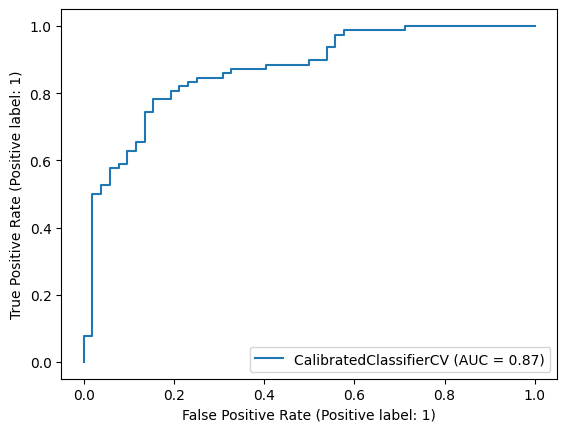

In [465]:
model_l1_svm.score(x_test, y_test), sklearn.metrics.RocCurveDisplay.from_estimator(model_l1_svm, x_test, y_test).roc_auc

In [701]:
pca = PCA(500)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [702]:
import xgboost as xgb

In [796]:
pls2 = sklearn.cross_decomposition.PLSRegression(n_components=5)
pls2.fit(x_train, y_train)
x_train_pls = pls2.transform(x_train)
x_test_pls = pls2.transform(x_test)

1, acc: 0.8692307692307693, auc: 0.893491124260355
2, acc: 0.8692307692307693, auc: 0.893491124260355
3, acc: 0.8692307692307693, auc: 0.893491124260355
4, acc: 0.8692307692307693, auc: 0.893491124260355
5, acc: 0.8692307692307693, auc: 0.893491124260355
6, acc: 0.8692307692307693, auc: 0.893491124260355
7, acc: 0.8692307692307693, auc: 0.893491124260355
8, acc: 0.8692307692307693, auc: 0.893491124260355
9, acc: 0.8692307692307693, auc: 0.893491124260355


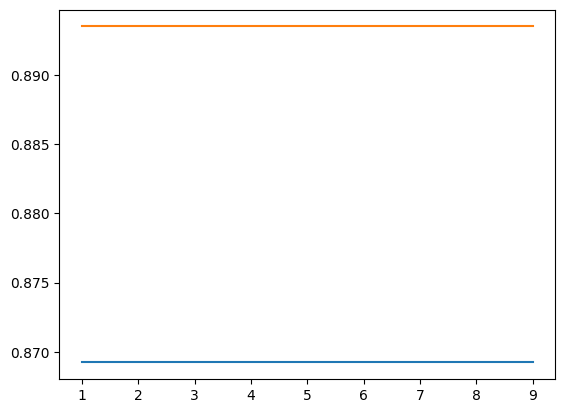

In [850]:
depths = []
accs = []
aucs = []
for i in range(1, 10):
    model = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=2, reg_alpha=0, scale_pos_weight=0.4/0.6, random_state=1)
    model.fit(x_train_pls, y_train)

    acc = (model.predict(x_test_pls) == y_test).mean()
    auc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(x_test_pls)[:, 1])
    
    depths.append(i)
    accs.append(acc)
    aucs.append(auc)

plt.plot(depths, accs)
plt.plot(depths, aucs)
plt.xticks(depths)

for d, acc, auc in zip(depths, accs, aucs):
    print(f"{d}, acc: {acc}, auc: {auc}")

In [844]:
mw = pls2.x_rotations_.dot(model.coef_)
mw.shape

(4005,)

<Axes: >

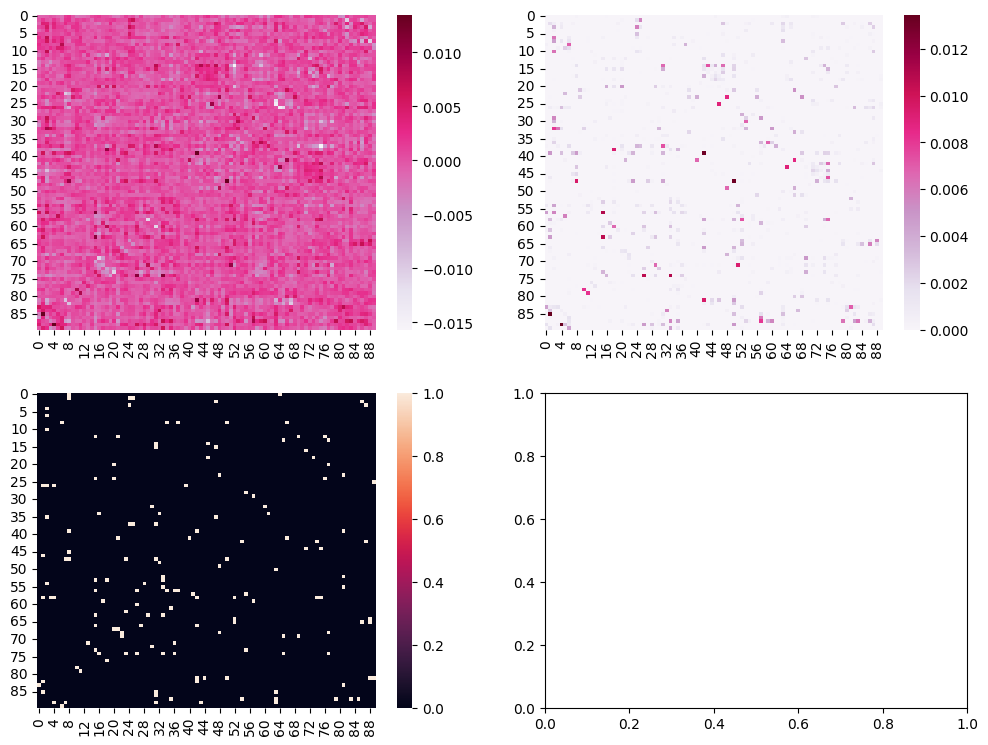

In [845]:
weights = hv.convert_triangle_to_mat(mw)
fcms, bcs = hv.get_brain_connectivity_functional_connectivity(inputs, weights)
fcms_thresh = [hv.threshold(f, 0.02) for f in fcms]
binarized_fcms_thresh = [hv.binarize(f) for f in fcms_thresh]

fig, ax = plt.subplots(2, 2, figsize=(12, 9))
sns.heatmap(np.rot90(np.mean(fcms, axis=0)), cmap="PuRd", ax=ax[0, 0])
sns.heatmap(np.rot90(np.mean(fcms_thresh, axis=0)), cmap="PuRd", ax=ax[0, 1])
sns.heatmap(np.rot90(binarized_fcms_thresh[0]), ax=ax[1, 0])

Text(0.5, 0.98, 'PLS Boosting Degree Centrality Of FCMS')

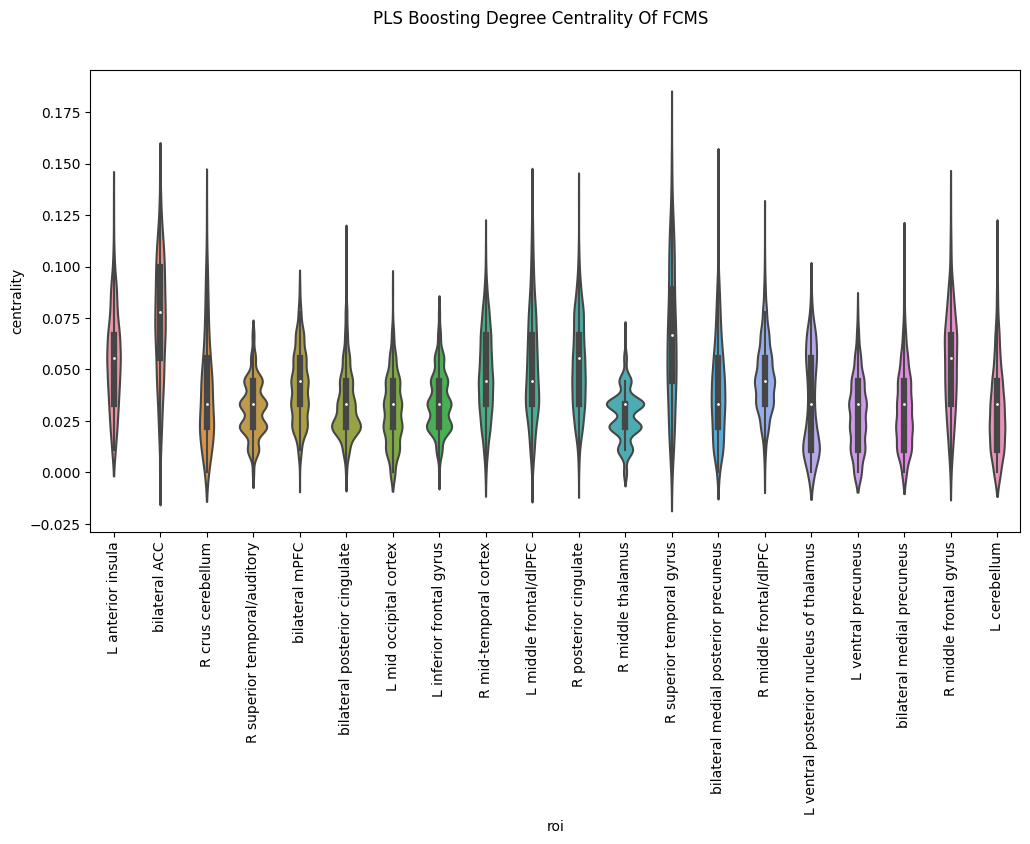

In [825]:
centrals = np.array([hv.degree_centrality(f) for f in binarized_fcms_thresh])
median_centrals = np.median(centrals.T, axis=1)

indices = np.argpartition(median_centrals, -20)[-20:]

df = hv.convert_centralities_to_df(centrals, indices)

fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)
fig.suptitle("PLS Boosting Degree Centrality Of FCMS")

In [826]:
os.makedirs("out/functional_connectivity/pls_boosting", exist_ok=True)
with open("out/functional_connectivity/pls_boosting/thresh_fcms.npy", "wb+") as f:
    np.save(f, fcms_thresh)
with open("out/functional_connectivity/pls_boosting/fcms.npy", "wb+") as f:
    np.save(f, fcms)

 Training model pls_boosting, fold 9/10

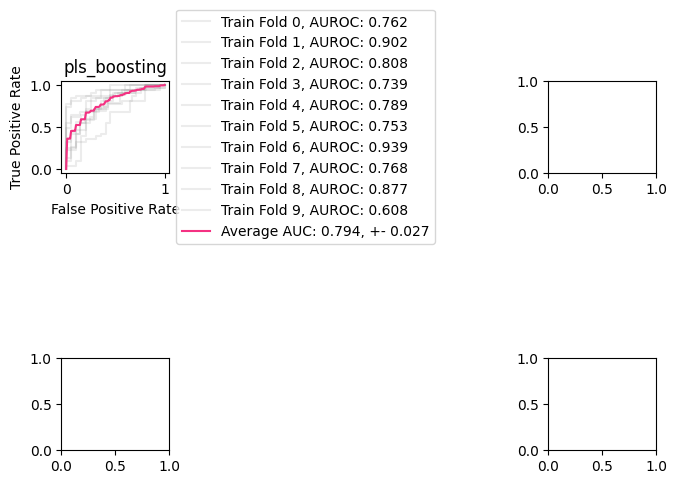

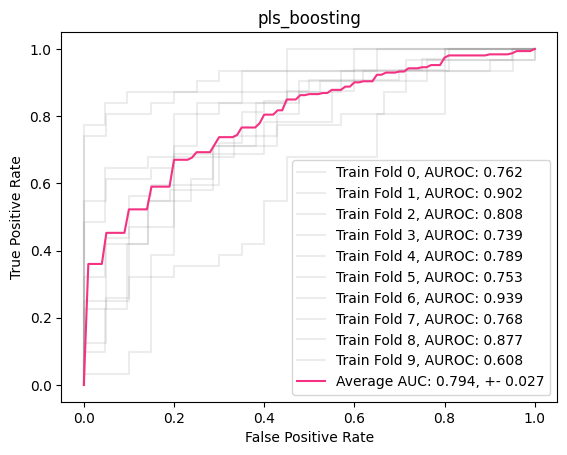

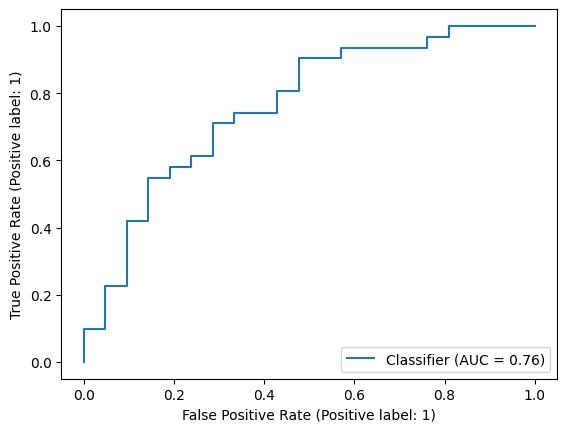

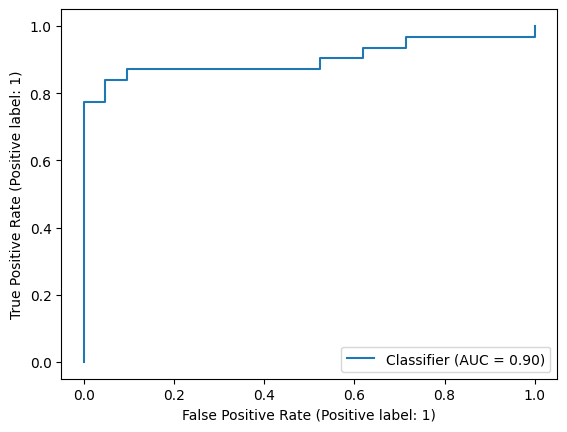

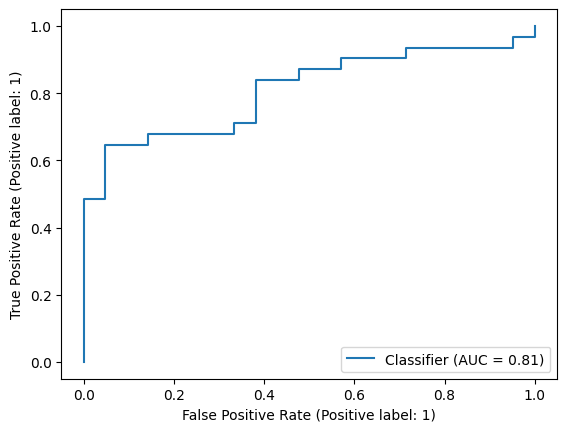

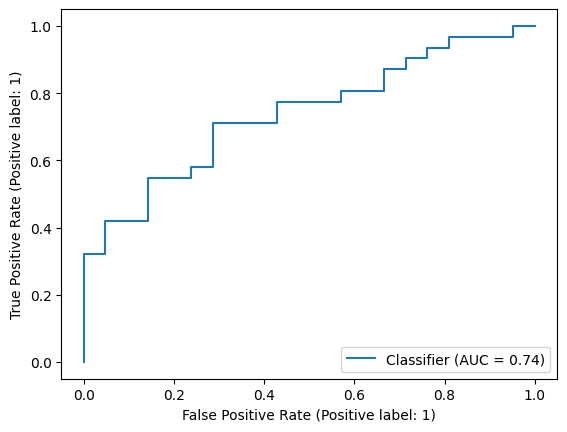

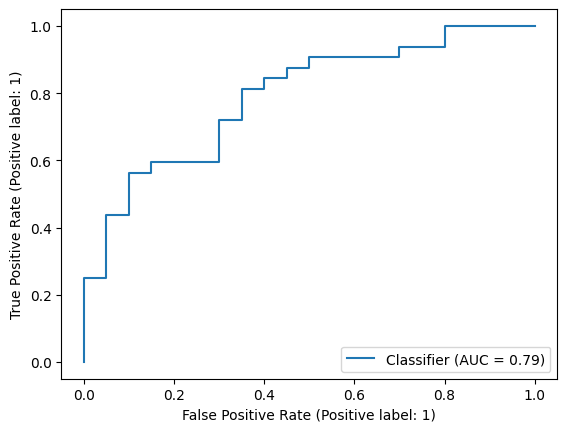

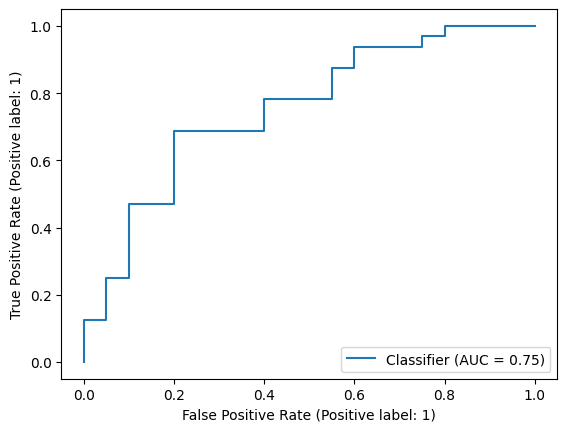

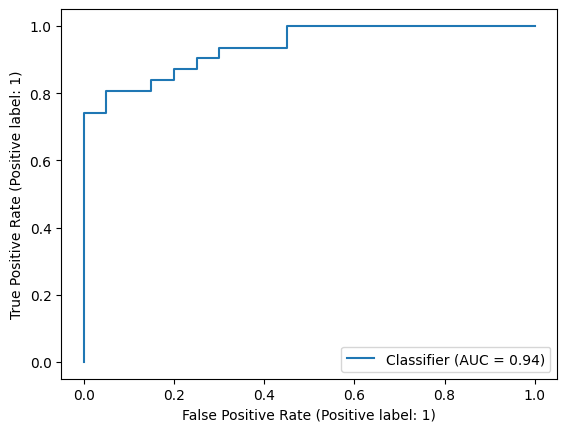

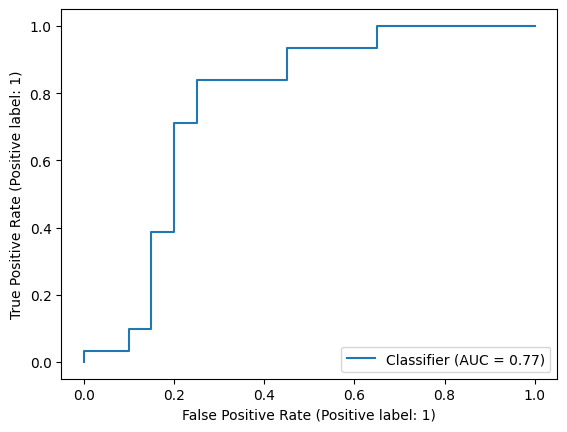

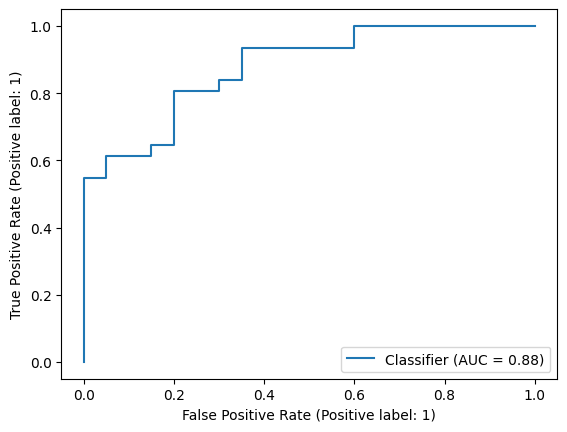

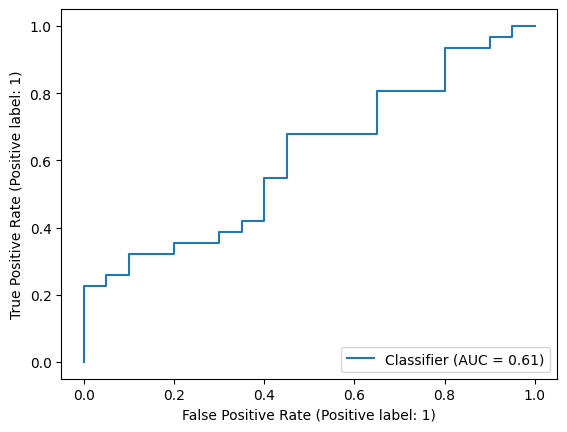

In [842]:
metrics = {
    "accuracy": lambda yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

folds = 10
tot_fig, tot_ax = plt.subplots(2, 2)

train_metrics = {}
for ax_idx, (model_name, model) in enumerate({"pls_boosting": None}.items()):
    skf = uu.StratifiedKFold(n_splits=folds)

    fig, ax = plt.subplots()

    train_metrics[model_name] = {}

    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
        train_metrics[model_name][j] = {}
        model_cln = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=2, reg_alpha=0, scale_pos_weight=0.4/0.6, random_state=1)

        fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
        fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]
        
        pls3 = sklearn.cross_decomposition.PLSRegression(n_components=5)
        pls3.fit(fold_x_train, fold_y_train)
        fold_x_train, fold_x_test = pls3.transform(fold_x_train), pls3.transform(fold_x_test)

        model_cln.fit(fold_x_train, fold_y_train)
        test_pred = model_cln.predict(fold_x_test) #if "pls" not in model_name else np.round(model_cln.predict(fold_x_test)[:, 0])
        test_pred_probs = model_cln.predict_proba(fold_x_test)[:, 1] #if "pls" not in model_name else model_cln.predict(fold_x_test)[:, 0]
        
        for metric_name, metric_fn in metrics.items():
            train_metrics[model_name][j][metric_name] = metric_fn(test_pred, test_pred_probs, fold_y_test)

        viz_data = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test) if "pls" not in model_name else \
                    sklearn.metrics.RocCurveDisplay.from_predictions(fold_y_test, test_pred_probs)
        fpr = viz_data.fpr
        tpr = viz_data.tpr

        train_metrics[model_name][j]["fpr_tpr"] = (fpr, tpr)
        train_metrics[model_name][j]["auc"] = viz_data.roc_auc

        roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        tot_ax[ax_idx%2, ax_idx//2].plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUROC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        train_metrics[model_name][j]["roc_plot"] = roc

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        print("\r", f"Training model {model_name}, fold {j}/{folds}", end="")

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    aucs = [m['auc'] for _, m in train_metrics[model_name].items()]
    mean_auc = np.mean(aucs)
    sd_auc = np.std(aucs)

    ci = 0.95 * sd_auc / np.sqrt(len(aucs))

    ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)  
    tot_ax[ax_idx%2, ax_idx//2].plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    box = tot_ax[ax_idx%2, ax_idx//2].get_position()
    tot_ax[ax_idx%2, ax_idx//2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    tot_ax[ax_idx%2, ax_idx//2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))


    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)
    tot_ax[ax_idx%2, ax_idx//2].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)

    train_metrics[model_name]["roc_curve"] = fig

tot_fig.subplots_adjust(left=0.07, right=1, wspace=3.5, hspace=2)

In [834]:
train_metrics

{'pls_boosting': {0: {'accuracy': 0.9807692307692307,
   'auc': 0.9984639016897081,
   'fpr_tpr': (array([0.        , 0.        , 0.        , 0.04761905, 0.04761905,
           1.        ]),
    array([0.        , 0.03225806, 0.96774194, 0.96774194, 1.        ,
           1.        ])),
   'roc_plot': [<matplotlib.lines.Line2D at 0x7f9f7c17c220>]},
  1: {'accuracy': 0.9807692307692307,
   'auc': 1.0,
   'fpr_tpr': (array([0., 0., 0., 1.]),
    array([0.        , 0.03225806, 1.        , 1.        ])),
   'roc_plot': [<matplotlib.lines.Line2D at 0x7f9f93985d00>]},
  2: {'accuracy': 0.9615384615384616,
   'auc': 1.0,
   'fpr_tpr': (array([0., 0., 0., 1.]),
    array([0.        , 0.03225806, 1.        , 1.        ])),
   'roc_plot': [<matplotlib.lines.Line2D at 0x7f9f95c7c580>]},
  3: {'accuracy': 0.9038461538461539,
   'auc': 0.9984639016897081,
   'fpr_tpr': (array([0.        , 0.        , 0.        , 0.04761905, 0.04761905,
           1.        ]),
    array([0.        , 0.03225806, 0.9

1, acc: 0.8615384615384616, auc: 0.8875739644970414
2, acc: 0.8615384615384616, auc: 0.8875739644970414
3, acc: 0.8615384615384616, auc: 0.8875739644970414
4, acc: 0.8615384615384616, auc: 0.8875739644970414
5, acc: 0.8615384615384616, auc: 0.8875739644970414
6, acc: 0.8615384615384616, auc: 0.8875739644970414
7, acc: 0.8615384615384616, auc: 0.8875739644970414
8, acc: 0.8615384615384616, auc: 0.8875739644970414
9, acc: 0.8615384615384616, auc: 0.8875739644970414


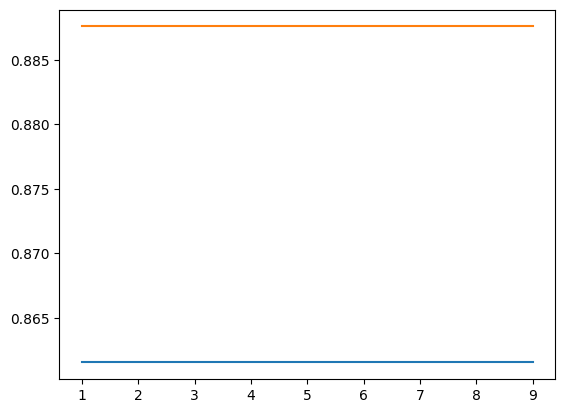

In [798]:
depths = []
accs = []
aucs = []
for i in range(1, 10):
    model = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=4, reg_alpha=0)
    model.fit(x_train_pls, y_train)

    acc = (model.predict(x_test_pls) == y_test).mean()
    auc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(x_test_pls)[:, 1])
    
    depths.append(i)
    accs.append(acc)
    aucs.append(auc)

plt.plot(depths, accs)
plt.plot(depths, aucs)
plt.xticks(depths)

for d, acc, auc in zip(depths, accs, aucs):
    print(f"{d}, acc: {acc}, auc: {auc}")

1, acc: 0.8384615384615385, auc: 0.8999013806706113
2, acc: 0.8384615384615385, auc: 0.8999013806706113
3, acc: 0.8384615384615385, auc: 0.8999013806706113
4, acc: 0.8384615384615385, auc: 0.8999013806706113
5, acc: 0.8384615384615385, auc: 0.8999013806706113
6, acc: 0.8384615384615385, auc: 0.8999013806706113
7, acc: 0.8384615384615385, auc: 0.8999013806706113
8, acc: 0.8384615384615385, auc: 0.8999013806706113
9, acc: 0.8384615384615385, auc: 0.8999013806706113


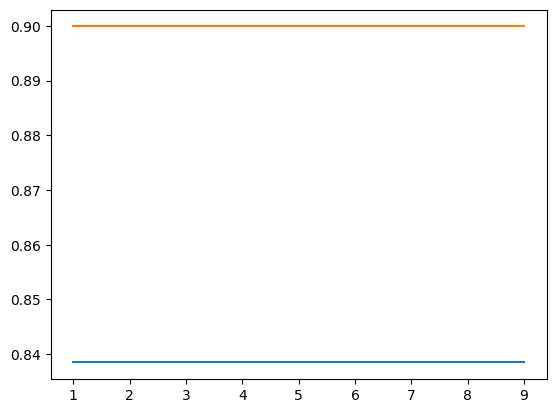

In [773]:
depths = []
accs = []
aucs = []
for i in range(1, 10):
    model = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=3, reg_alpha=0)
    model.fit(x_train_pls, y_train)

    acc = (model.predict(x_test_pls) == y_test).mean()
    auc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(x_test_pls)[:, 1])
    
    depths.append(i)
    accs.append(acc)
    aucs.append(auc)

plt.plot(depths, accs)
plt.plot(depths, aucs)
plt.xticks(depths)

for d, acc, auc in zip(depths, accs, aucs):
    print(f"{d}, acc: {acc}, auc: {auc}")

In [752]:
np.argmax(accs)

7

#### 